<a href="https://colab.research.google.com/github/SerejkaP/ML_Homeworks/blob/main/HW4/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

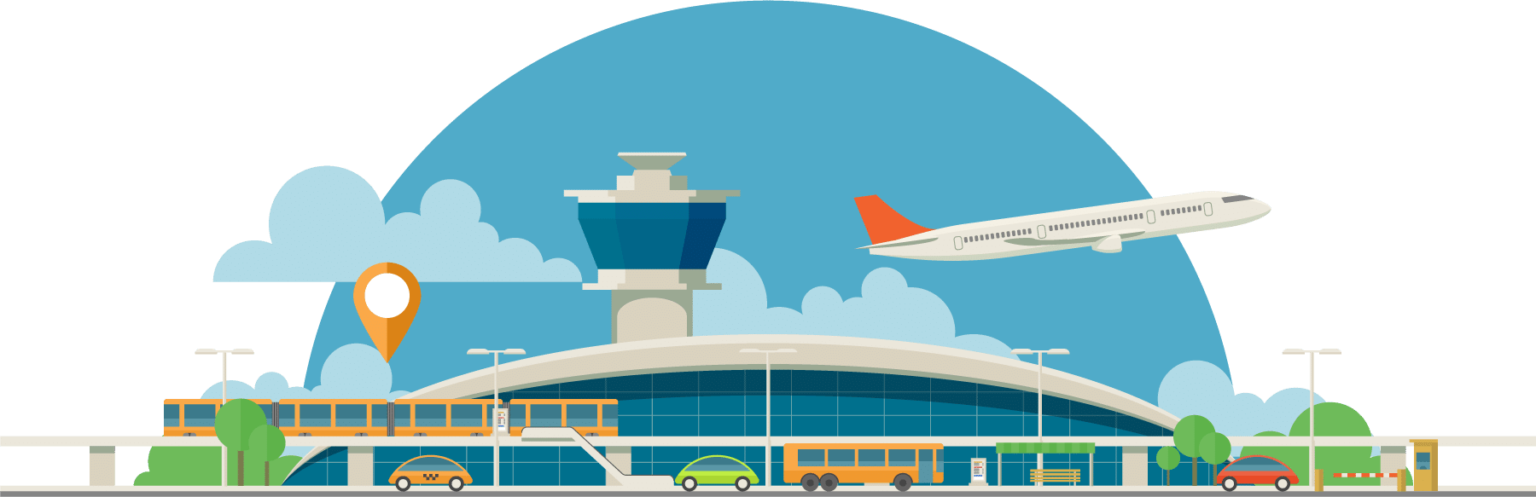

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5a2ceebb8a2d853294578c79812b3a0178c5d5067c7becb31ac0a3ae3286e351
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-02 09:30:45--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-02 09:30:46 (1.14 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

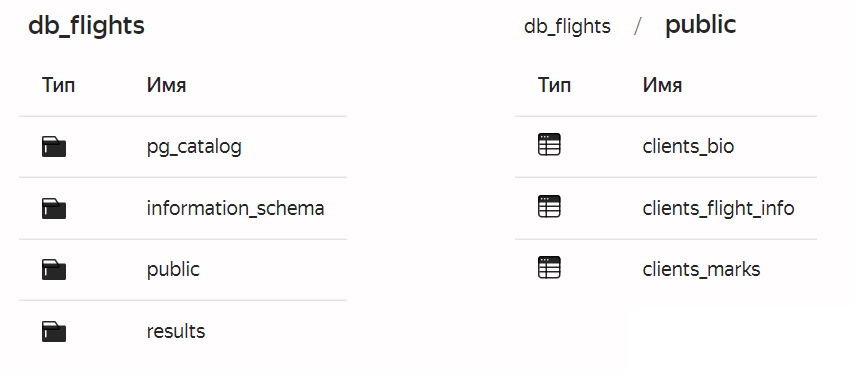



In [4]:
connection = psycopg2.connect("host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net port=6432 dbname=db_flights user=mlhs_student password=mlhs_student sslmode=verify-full target_session_attrs=read-write")

Сперва просмотрю столбцы таблиц, чтобы понять по каким из них объединять

In [5]:
cur = connection.cursor()
cur.execute('''
SELECT column_name
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = 'clients_bio'
''')
print(cur.fetchall())
cur.execute('''
SELECT column_name
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = 'clients_flight_info'
''')
print(cur.fetchall())
cur.execute('''
SELECT column_name
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = 'clients_marks'
''')
print(cur.fetchall())
cur.close()

[('id',), ('gender',), ('age',)]
[('id',), ('Customer Type',), ('Type of Travel',), ('class',), ('Flight Distance',), ('Departure Delay in Minutes',), ('Arrival Delay in Minutes',)]
[('id',), ('Inflight wifi service',), ('Departure/Arrival time convenient',), ('Ease of Online booking',), ('Gate location',), ('Food and drink',), ('Online boarding',), ('Seat comfort',), ('Inflight entertainment',), ('On-board service',), ('Leg room service',), ('Baggage handling',), ('Checkin service',), ('Inflight service',), ('cleanliness',), ('satisfaction',)]


In [6]:
query = '''
SELECT *
FROM clients_bio AS cb
JOIN clients_flight_info cfi ON cfi.id = cb.id
JOIN clients_marks cm ON cm.id = cb.id
'''
df = pd.read_sql(query, connection)

<ipython-input-6-3c7faaa85502>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


В таблице остались столбцы с id, их стоит удалить

In [7]:
df.drop('id', inplace=True, axis=1)

In [8]:
df.head()

gender   age      Customer Type   Type of Travel     class Flight Distance  \
0    Male  43.0     Loyal Customer  Business travel  Business          1963.0   
1    Male  24.0  disloyal Customer  Business travel       Eco           453.0   
2  Female  61.0     Loyal Customer  Personal Travel       Eco           821.0   
3    Male  35.0  disloyal Customer  Business travel  Business           212.0   
4  Female  46.0     Loyal Customer  Business travel  Business            67.0   

  Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
0                        0.0                      0.0                   3.0   
1                       16.0                     30.0                   2.0   
2                        0.0                      0.0                   2.0   
3                        0.0                      0.0                   2.0   
4                        0.0                      0.0                   3.0   

  Departure/Arrival time convenient  ... Online boarding Seat comfort  \
0                               3.0  ...             4.0          5.0   
1                               2.0  ...             2.0          5.0   
2                               5.0  ...             1.0          5.0   
3                               2.0  ...             2.0          2.0   
4                               3.0  ...             5.0          4.0   

  Inflight entertainment On-board service Leg room service Baggage handling  \
0                    5.0              5.0              5.0              5.0   
1                    5.0              2.0              4.0              4.0   
2                    5.0              5.0              2.0              5.0   
3                    2.0              4.0              5.0              5.0   
4                    4.0              4.0              4.0              4.0   

  Checkin service Inflight service cleanliness             satisfaction  
0             4.0              5.0         4.0                satisfied  
1             2.0              4.0         5.0  neutral or dissatisfied  
2             5.0              5.0         1.0  neutral or dissatisfied  
3             5.0              4.0         2.0  neutral or dissatisfied  
4             5.0              4.0         5.0                satisfied  

[5 rows x 23 columns]

In [9]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

Все значения в dataframe типа object. Проверю, какие значения представлены в численном виде...

In [10]:
df.describe().T['top']

gender                                                Female
age                                                     39.0
Customer Type                                 Loyal Customer
Type of Travel                               Business travel
class                                               Business
Flight Distance                                        337.0
Departure Delay in Minutes                               0.0
Arrival Delay in Minutes                                 0.0
Inflight wifi service                                    2.0
Departure/Arrival time convenient                        4.0
Ease of Online booking                                   3.0
Gate location                                            3.0
Food and drink                                           4.0
Online boarding                                          4.0
Seat comfort                                             4.0
Inflight entertainment                                   4.0
On-board service                                         4.0
Leg room service                                         4.0
Baggage handling                                         4.0
Checkin service                                          4.0
Inflight service                                         4.0
cleanliness                                              4.0
satisfaction                         neutral or dissatisfied
Name: top, dtype: object

In [11]:
float_columns = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Inflight wifi service',
   'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink',
   'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
   'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness']
df[float_columns] = df[float_columns].astype(float)

Проверю выбросы, сравнив максимальные и минимальные значения с квантилями

In [12]:
df.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [13]:
df.select_dtypes(include=['float']).quantile([0.01, 0.99])

age  Flight Distance  Departure Delay in Minutes  \
0.01   8.0            101.0                         0.0   
0.99  72.0           3904.0                       183.0   

      Arrival Delay in Minutes  Inflight wifi service  \
0.01                       0.0                    0.0   
0.99                     185.0                    5.0   

      Departure/Arrival time convenient  Ease of Online booking  \
0.01                                0.0                     0.0   
0.99                                5.0                     5.0   

      Gate location  Food and drink  Online boarding  Seat comfort  \
0.01            1.0             1.0              0.0           1.0   
0.99            5.0             5.0              5.0           5.0   

      Inflight entertainment  On-board service  Leg room service  \
0.01                     1.0               1.0               1.0   
0.99                     5.0               5.0               5.0   

      Baggage handling  Checkin service  Inflight service  cleanliness  
0.01               1.0              1.0               1.0          1.0  
0.99               5.0              5.0               5.0          5.0

**Есть выбросы во всех числовых признаках**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129549 entries, 0 to 129548
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      1295

**Во всех числовых признаках присутствуют пропуски**

Проверю наличие пропусков в категориальных признаках

In [15]:
for col in df.select_dtypes(include=['object']).columns:
  print(col, df[col].unique())

gender ['Male' 'Female']
Customer Type ['Loyal Customer' 'disloyal Customer' 'nan']
Type of Travel ['Business travel' 'Personal Travel' 'nan']
class ['Business' 'Eco' 'Eco Plus' 'nan']
satisfaction ['satisfied' 'neutral or dissatisfied' '-']


**Пропуски есть в категориальных столбцах** *Customer Type, Type of Travel, class, satisfaction*

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

Построю matrix

<Axes: >

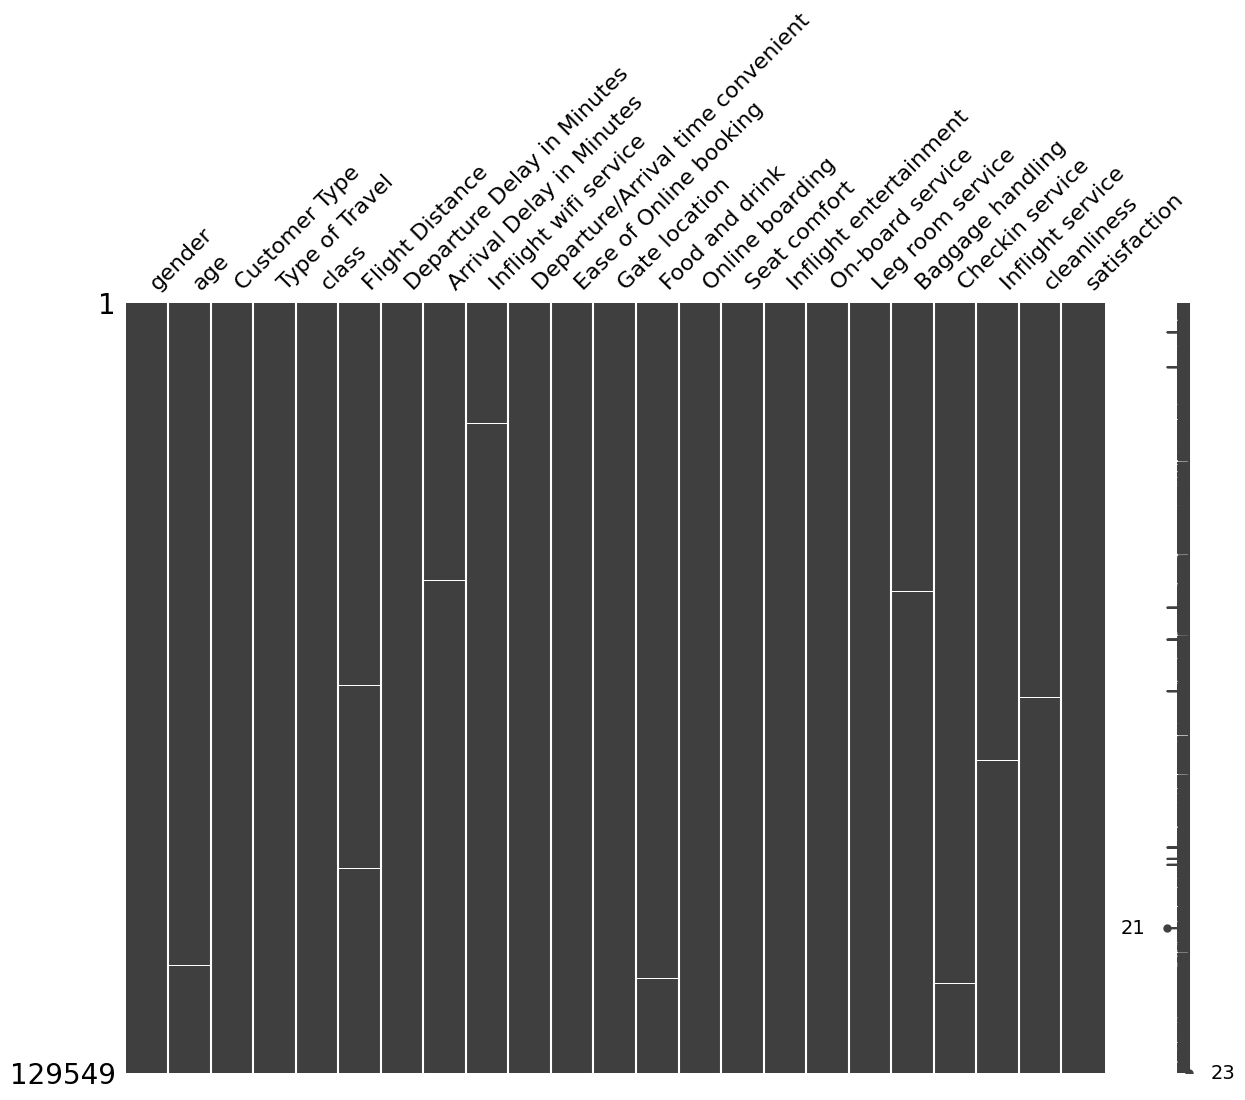

In [ ]:
missingno.matrix(df, figsize=(14, 10))

Построю столбчатую диаграмму в логарифмической шкале

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

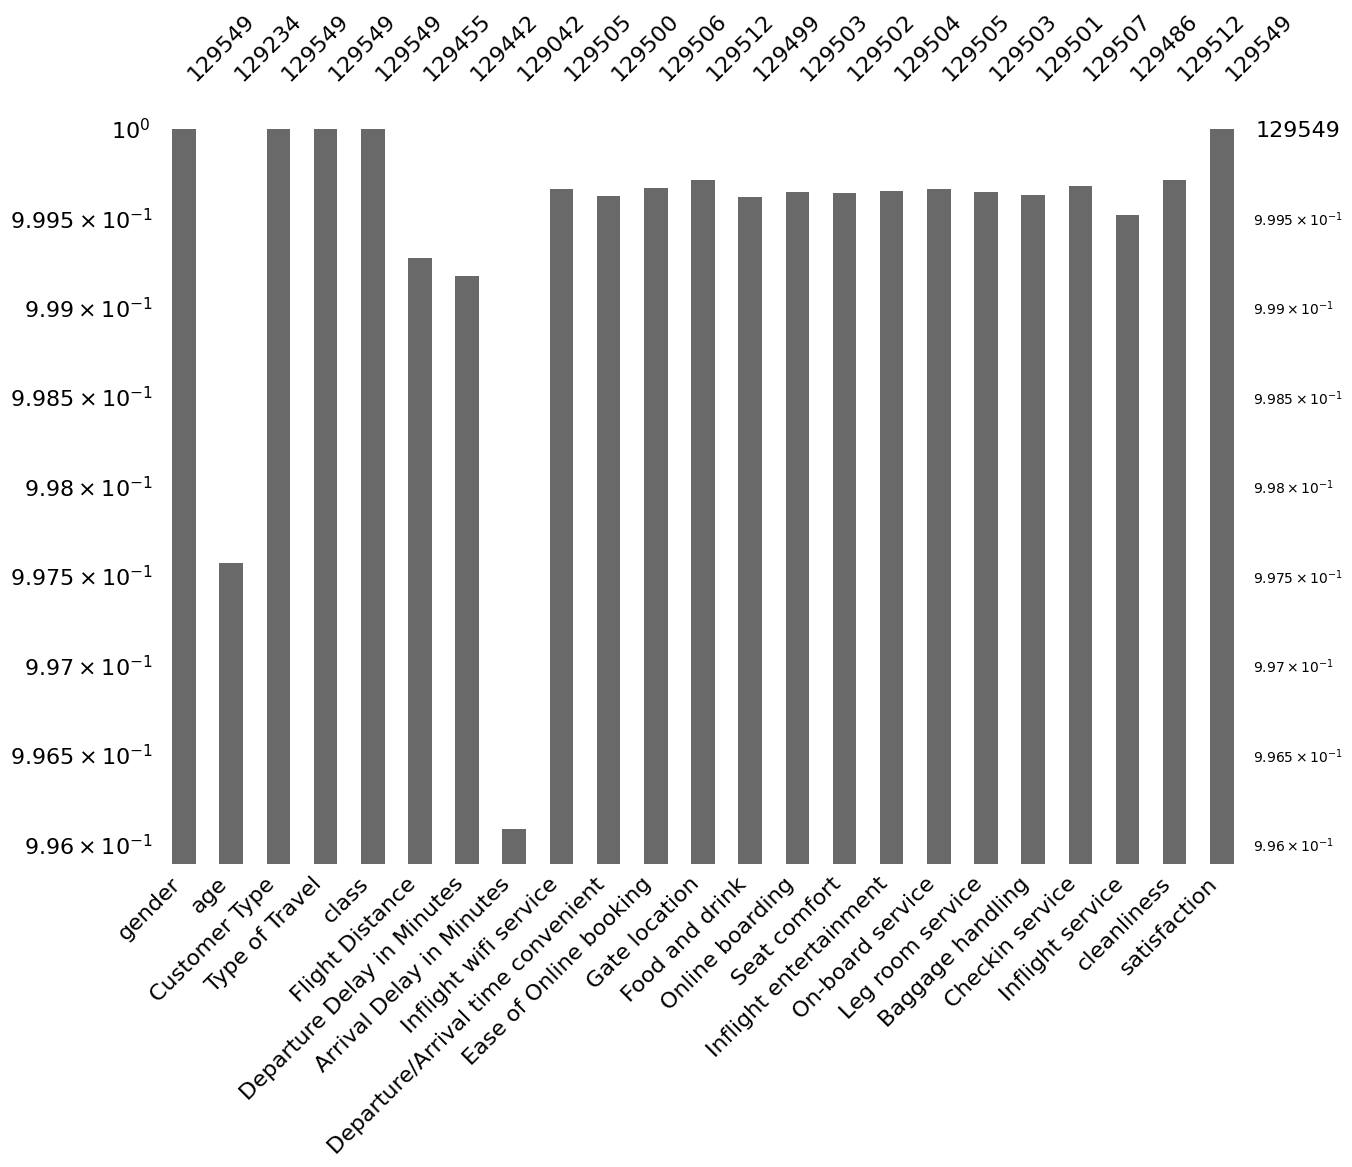

In [ ]:
missingno.bar(df, figsize=(14, 10), log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [16]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  43.0     Loyal Customer  Business travel  Business   
1         Male  24.0  disloyal Customer  Business travel       Eco   
2       Female  61.0     Loyal Customer  Personal Travel       Eco   
3         Male  35.0  disloyal Customer  Business travel  Business   
4       Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel       Eco   
129543    Male  66.0     Loyal Customer  Personal Travel       Eco   
129544  Female  59.0     Loyal Customer  Personal Travel       Eco   
129545    Male  61.0     Loyal Customer  Personal Travel       Eco   
129546    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                1963.0                         0.0                       0.0   
1                 453.0                        16.0                      30.0   
2                 821.0                         0.0                       0.0   
3                 212.0                         0.0                       0.0   
4                  67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129542            447.0                        23.0                      16.0   
129543            337.0                       199.0                     213.0   
129544            308.0                        32.0                      24.0   
129545            337.0                         0.0                       0.0   
129546            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         2.0                                5.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    1.0                                3.0  ...   
129543                    2.0                                4.0  ...   
129544                    3.0                                5.0  ...   
129545                    2.0                                4.0  ...   
129546                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   4.0           5.0                     5.0   
1                   2.0           5.0                     5.0   
2                   1.0           5.0                     5.0   
3                   2.0           2.0                     2.0   
4                   5.0           4.0                     4.0   
...                 ...           ...                     ...   
129542              1.0           3.0                     3.0   
129543              5.0           5.0                     5.0   
129544              5.0           5.0                     3.0   
129545              2.0           3.0                     3.0   
129546              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    5.0               5.0               5.0              4.0   
1                    2.0               4.0               4.0              2.0   
2                    5.0               2.0               5.0              5.0   
3                    4.0               5.0               5.0              5.0   
4                    4.0               4.0               4.0              5.0   
...                  ...               ...        

In [17]:
assert df_train.shape == (103_644, 23)

In [18]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
5         Male  36.0  Loyal Customer  Business travel  Business   
7       Female  70.0  Loyal Customer  Personal Travel       Eco   
12        Male  66.0  Loyal Customer  Personal Travel       Eco   
19      Female  60.0  Loyal Customer  Business travel  Business   
24        Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129531    Male  38.0  Loyal Customer  Business travel       Eco   
129535    Male  16.0  Loyal Customer  Personal Travel       Eco   
129539  Female  43.0  Loyal Customer  Personal Travel       Eco   
129547    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129548    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
5                3655.0                        40.0                      71.0   
7                 108.0                        50.0                      41.0   
12                562.0                        88.0                      84.0   
19               3756.0                        36.0                      24.0   
24                802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129531            337.0                        92.0                      82.0   
129535            308.0                         2.0                       0.0   
129539            308.0                         0.0                       0.0   
129547            447.0                         0.0                       0.0   
129548            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
5                         1.0                                1.0  ...   
7                         5.0                                4.0  ...   
12                        2.0                                5.0  ...   
19                        4.0                                4.0  ...   
24                        1.0                                2.0  ...   
...                       ...                                ...  ...   
129531                    4.0                                3.0  ...   
129535                    3.0                                4.0  ...   
129539                    2.0                                4.0  ...   
129547                    3.0                                4.0  ...   
129548                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
5                  1.0              3.0           3.0                     3.0   
7                  4.0              4.0           4.0                     3.0   
12                 5.0              2.0           5.0                     5.0   
19                 2.0              4.0           5.0                     4.0   
24                 2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129531             4.0              5.0           4.0                     4.0   
129535             1.0              3.0           5.0                     1.0   
129539             3.0              5.0           5.0                     4.0   
129547             4.0              3.0           4.0                     4.0   
129548             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
5                    3.0               3.0               1.0              4.0   
7                    3.0               0.0               3.0              5.0   
12                   3.0               5.0               2.0              5.0   
19                   4.0               4.0              

In [19]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [21]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

Вычислю моду для тренировочной выборке. Заполню вычисленным значением тренировочную, тестовую и валидационную выборку

In [22]:
for column in X_train.select_dtypes(include=['float']).columns:
  mode = X_train[X_train[column].notna()][column].mode()[0]
  X_train[column] = X_train[column].fillna(mode)
  X_val[column] = X_val[column].fillna(mode)
  df_test[column] = df_test[column].fillna(mode)
for column in X_train.select_dtypes(include=['object']).columns:
  mode = X_train[X_train[column]!='nan'][column].mode()[0]
  X_train[column] = X_train[column].map(lambda val: mode if val == 'nan' else val)
  X_val[column] = X_val[column].map(lambda val: mode if val == 'nan' else val)
  df_test[column] = df_test[column].map(lambda val: mode if val == 'nan' else val)

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [23]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [24]:
X_train.describe(include='object')

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

**Вывод:** Признаки имеют большой разброс значений, хотя большая их часть находится в не таком большом диапазоне.  
В данных присутствуют аномалии: очень большие значения расстояния полета и задержек. Также встречаются оценки выше 5 и очень большой возраст, что тоже может быть аномалией.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [25]:
quantiles = X_train.select_dtypes(include=['float']).quantile(0.996)
train_quantiles = (X_train.select_dtypes(include=['float']) <= quantiles).all(axis=1)
val_quantiles = (X_val.select_dtypes(include=['float']) <= quantiles).all(axis=1)
X_train = X_train[train_quantiles]
y_train = y_train[train_quantiles]

X_val = X_val[val_quantiles]
y_val = y_val[val_quantiles]

In [26]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71395, 22), (71395,), (30600, 22), (30600,))

In [27]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [28]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [29]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [ ]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      plt.figure(figsize=(10, 6))
      sns.countplot(x=col, hue=y, data=df)
      plt.title(f'Столбчатая диаграмма количества {col}')
      plt.xlabel(col)
      plt.ylabel('Количество')
      plt.show()


In [ ]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      sns.kdeplot(data=df, x=col, hue=y, fill=True)
      plt.title(f'Kdeplot {col}')
      plt.xlabel(col)
      plt.ylabel('Плотность')

      plt.subplot(1, 2, 2)
      sns.boxplot(data=df, hue=y, y=col, gap=1.8, palette='bright', legend=True)
      plt.title(f'Boxplot {col}')
      plt.xlabel('satisfaction')
      plt.ylabel(col)
      plt.show()

In [ ]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      plt.figure(figsize=(10, 6))
      sns.countplot(x=col, hue=y, data=df)
      plt.title(f'Столбчатая диаграмма количества {col}')
      plt.xlabel(col)
      plt.ylabel('Количество')
      plt.show()

Отрисовка.

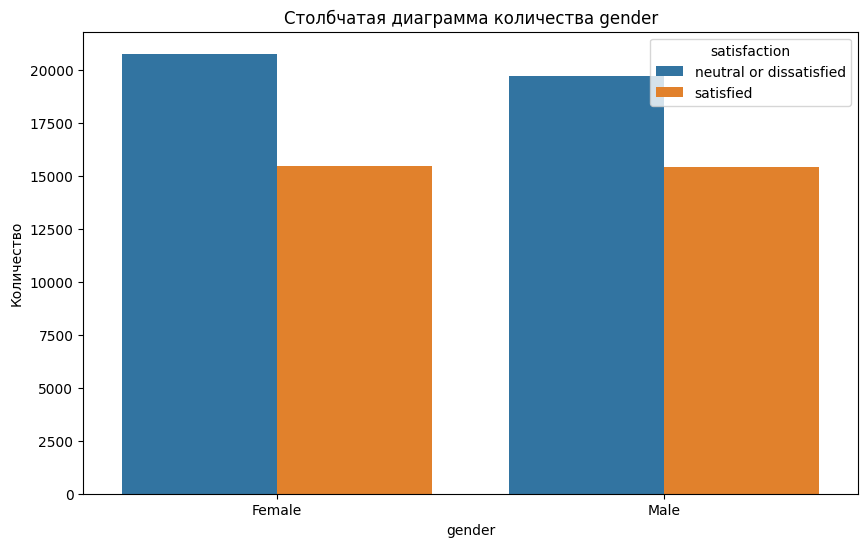

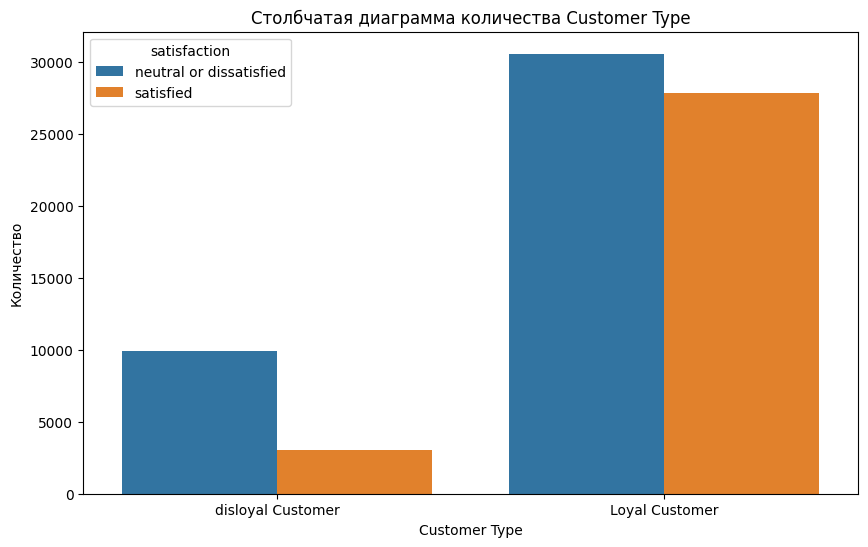

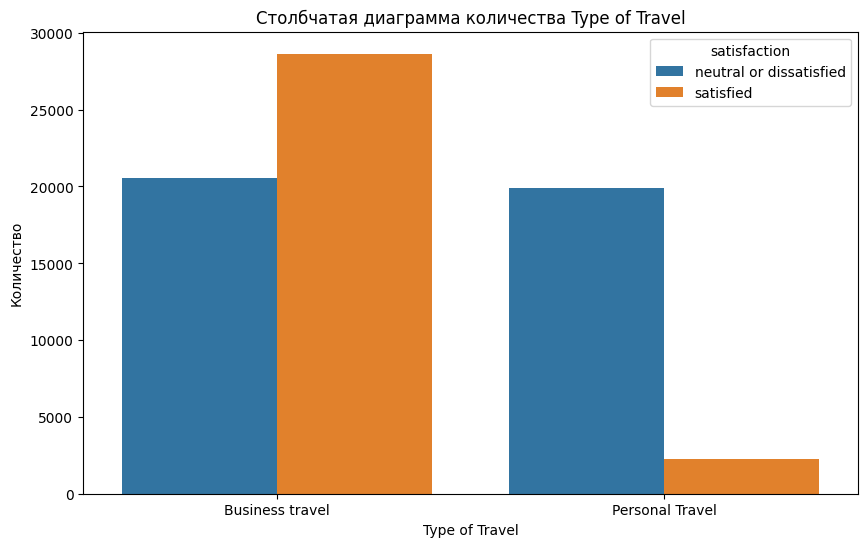

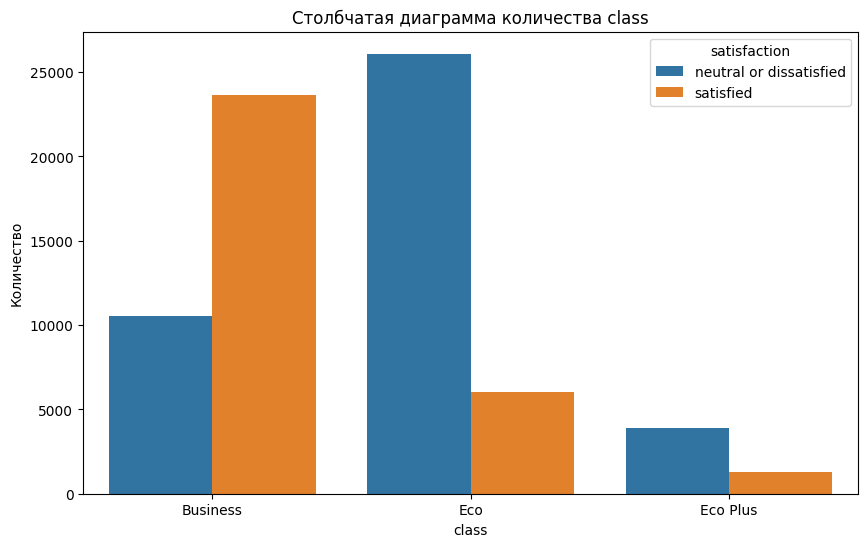

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

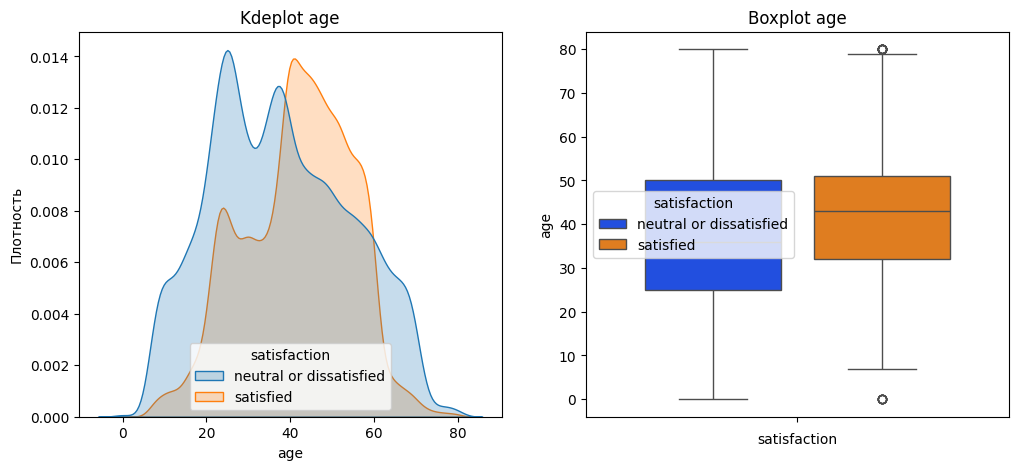

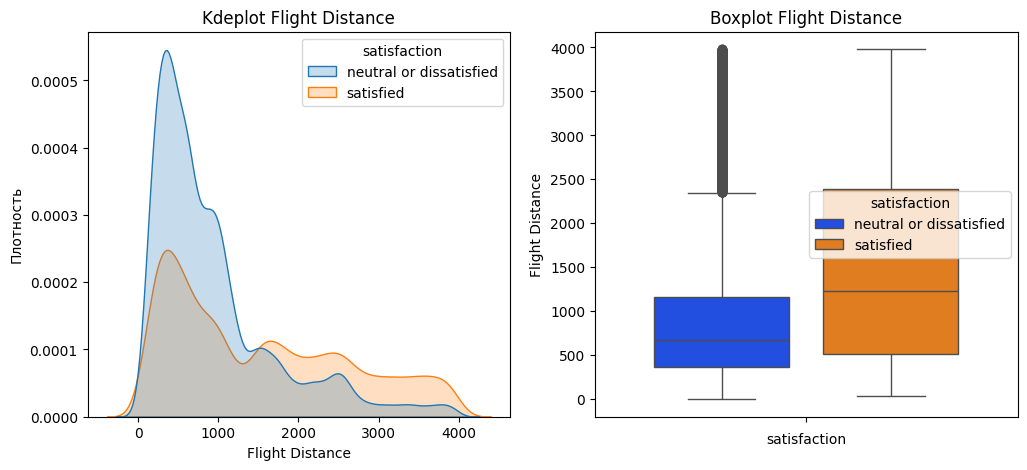

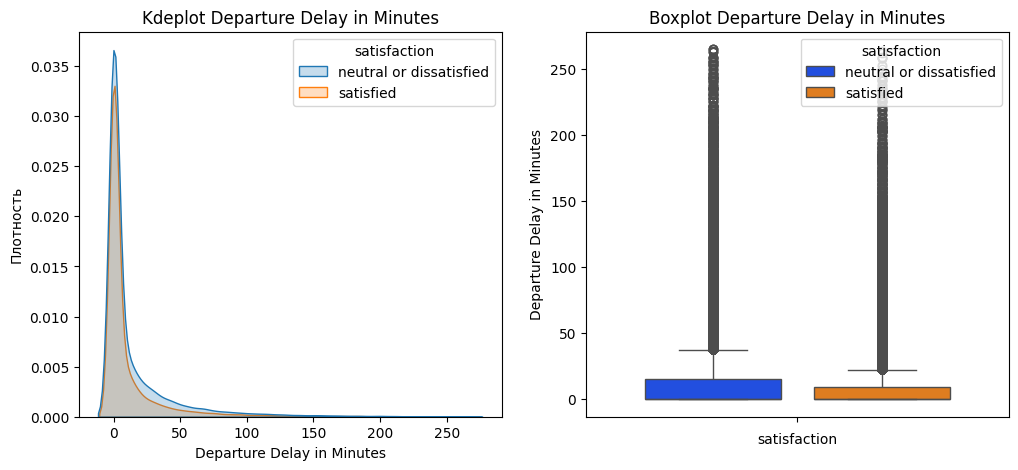

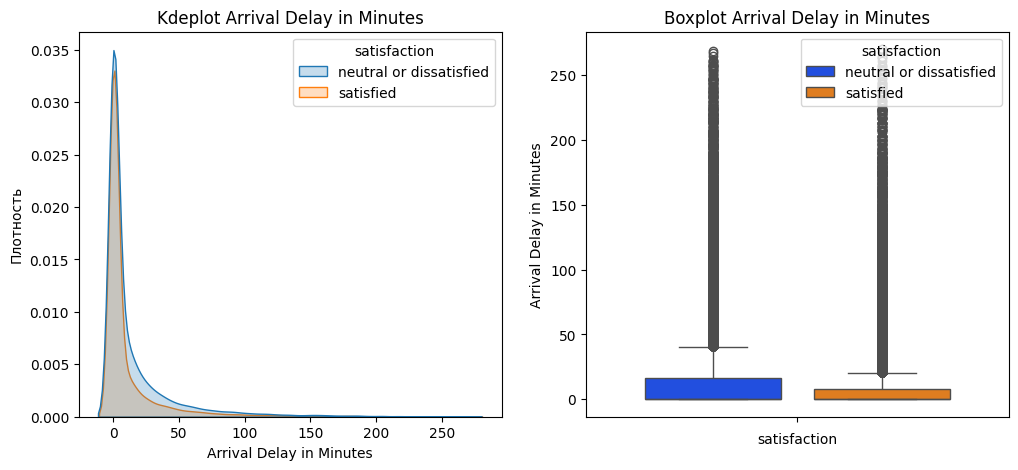

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

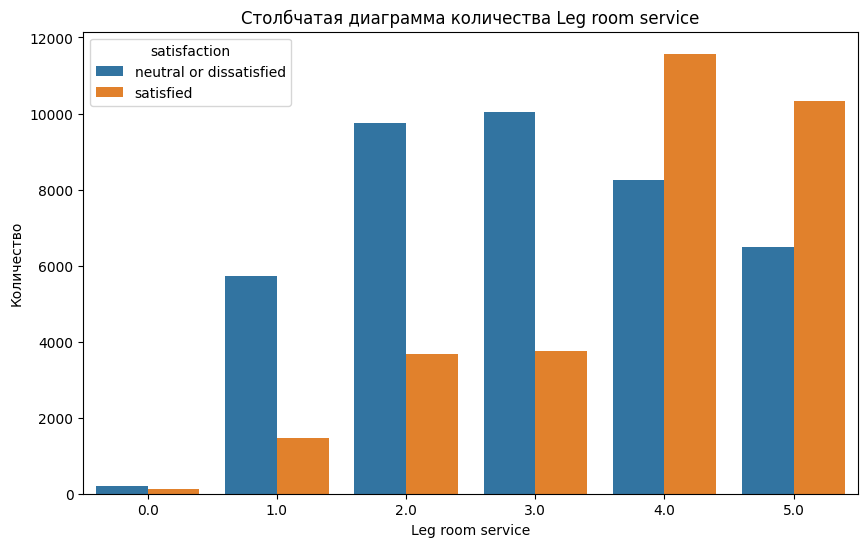

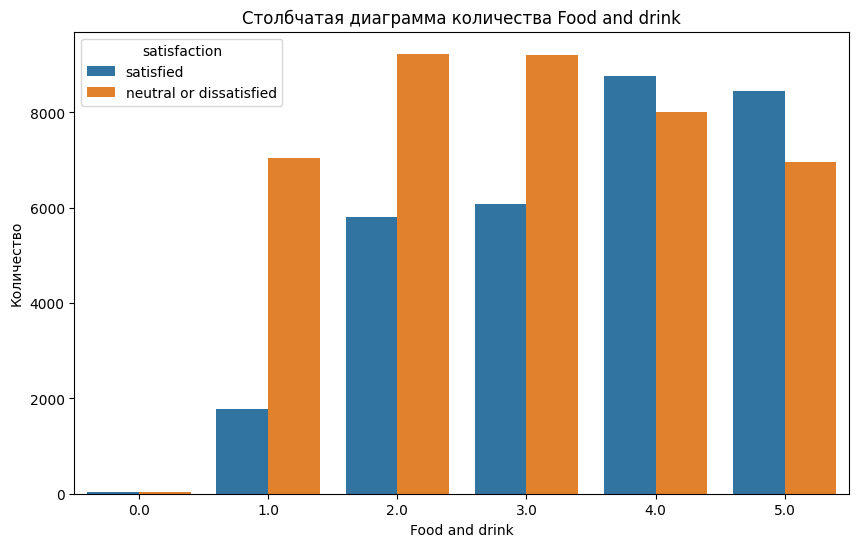

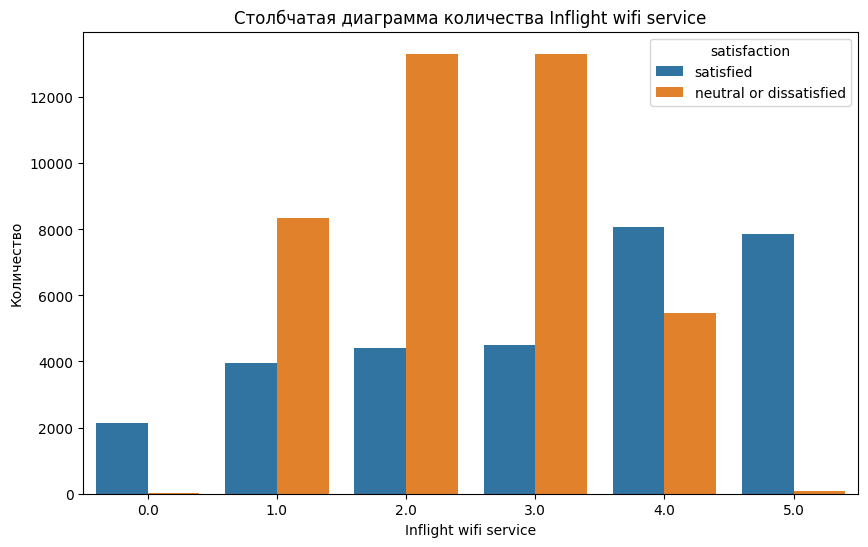

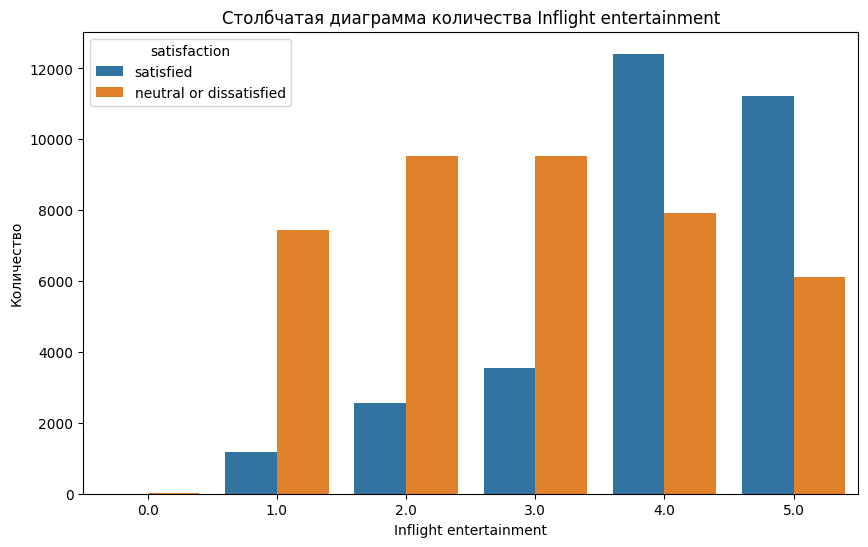

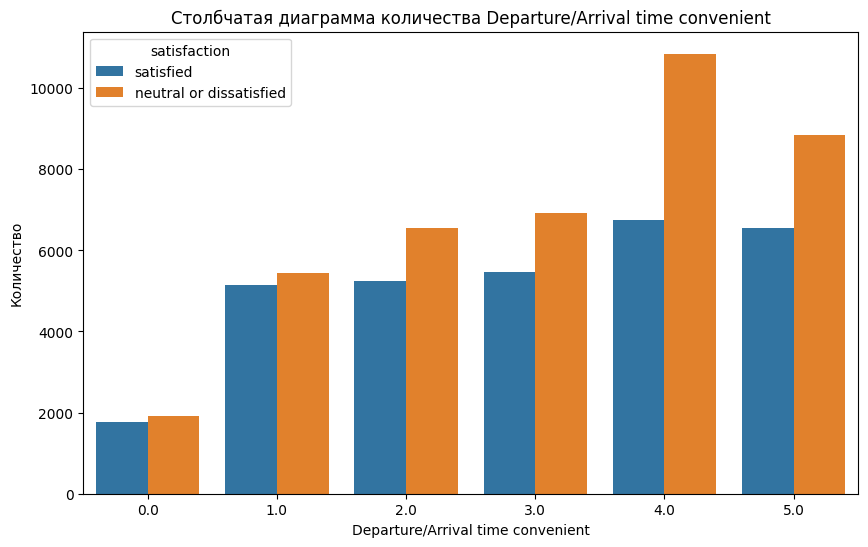

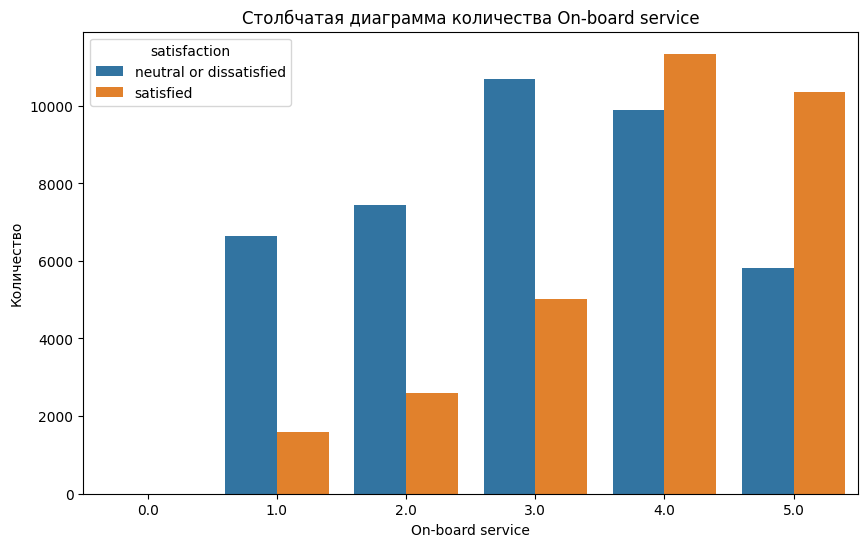

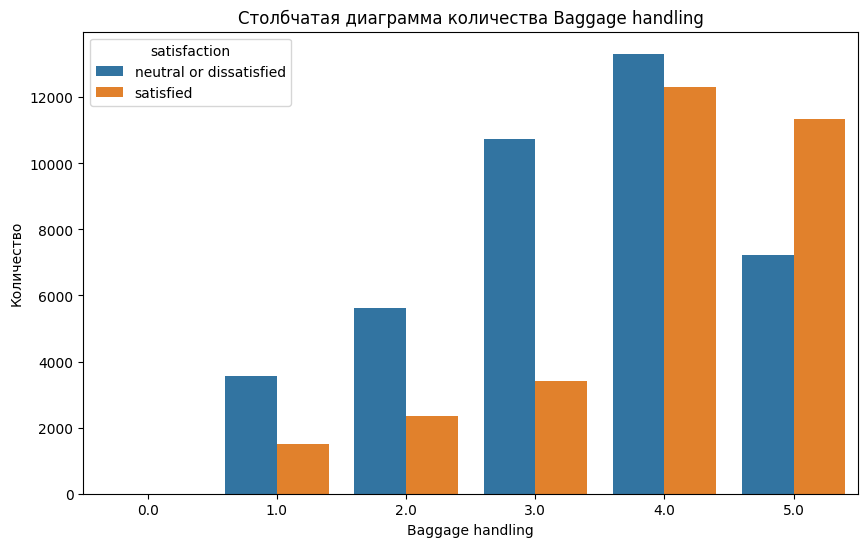

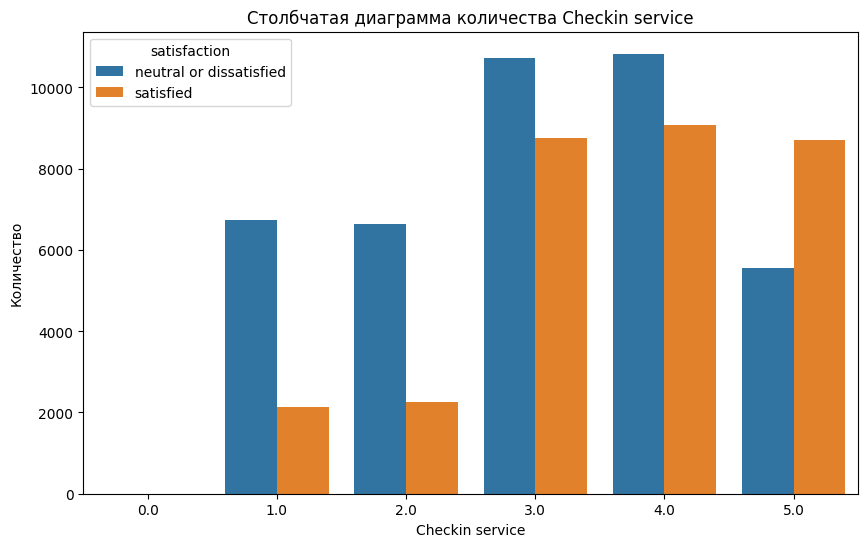

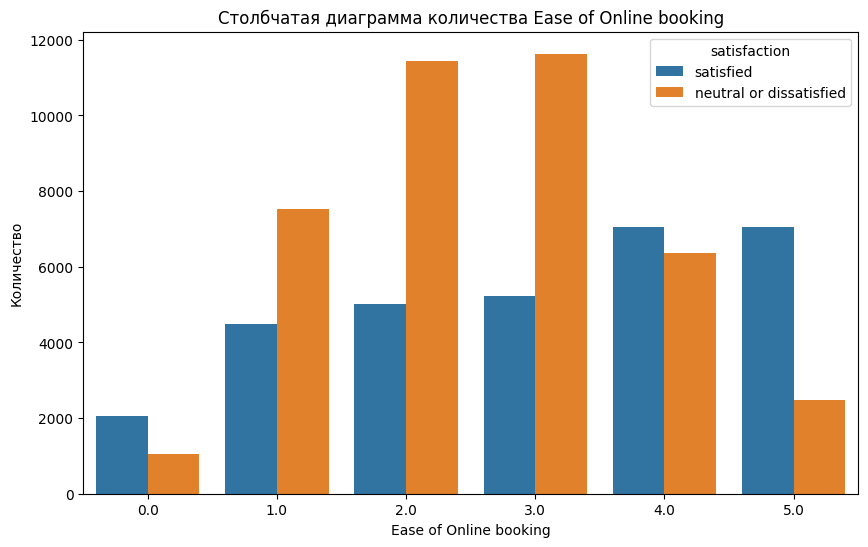

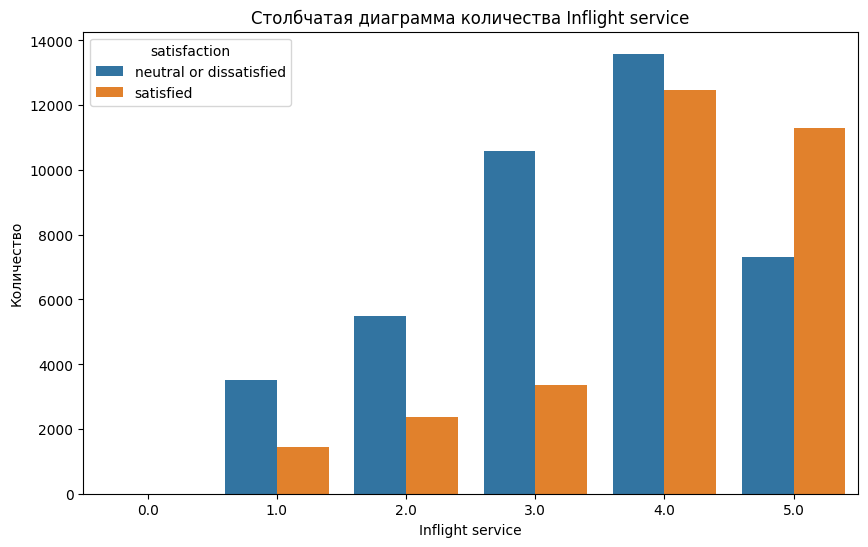

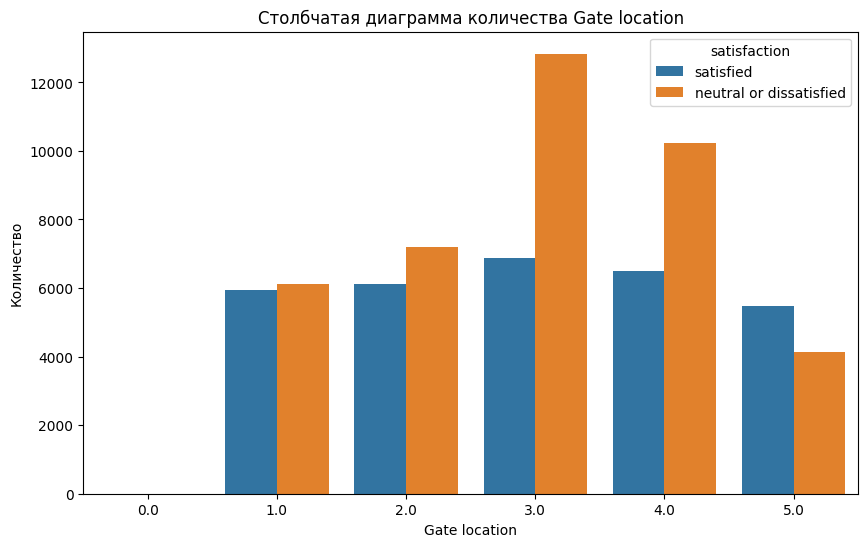

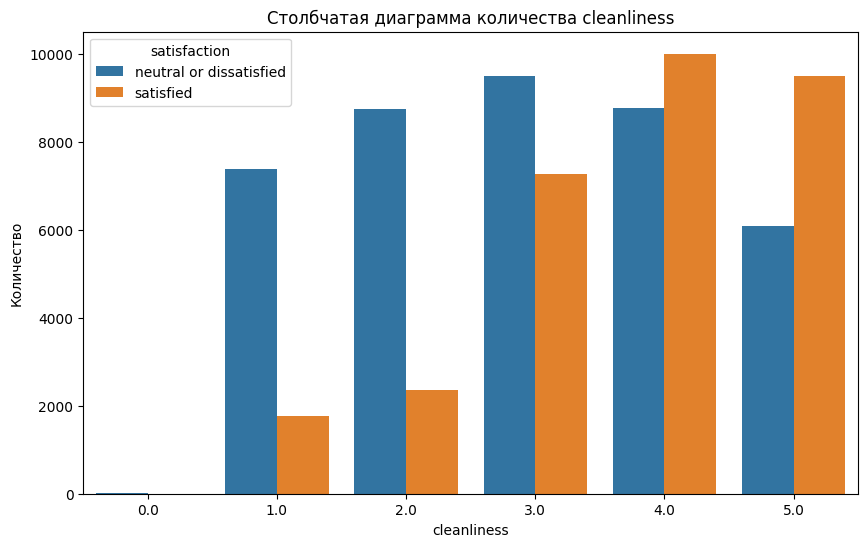

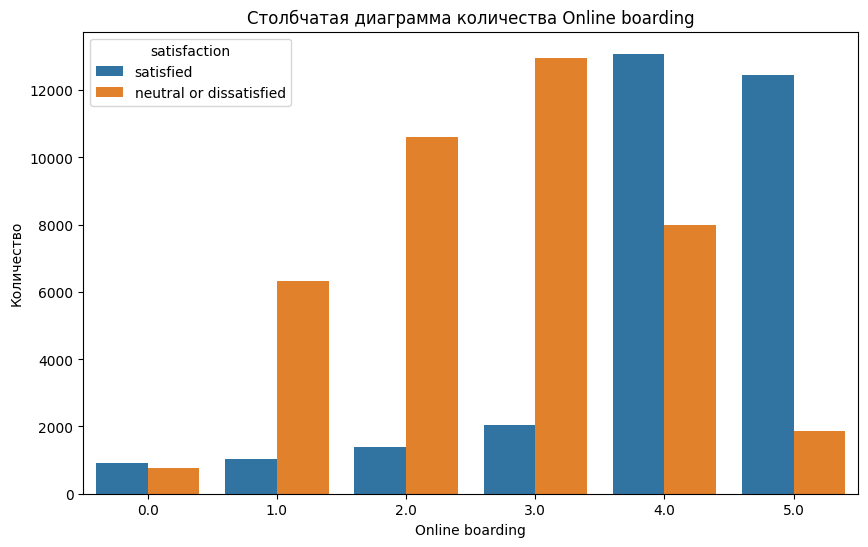

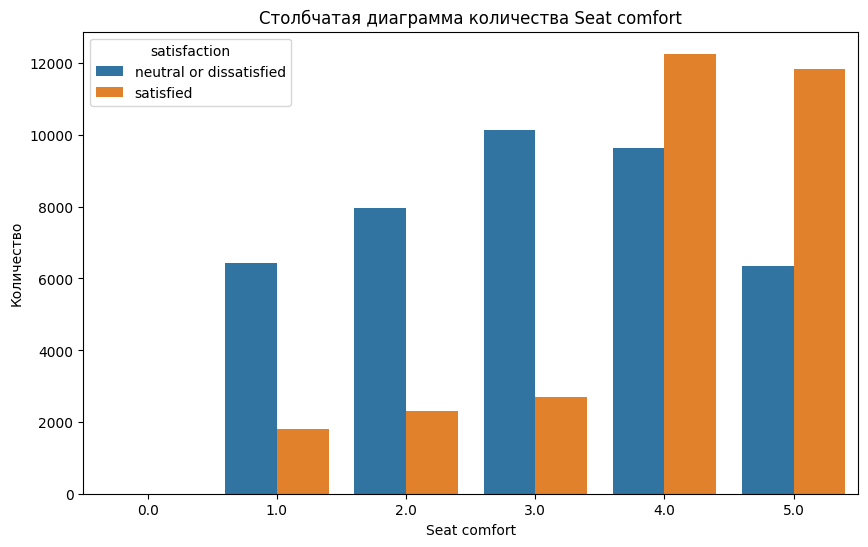

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

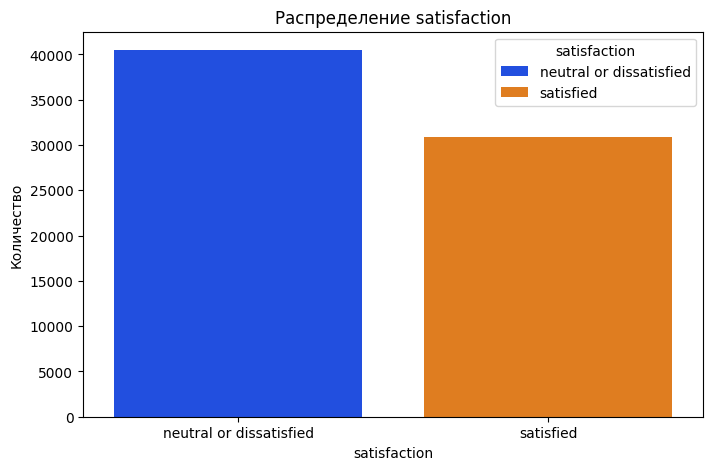

In [ ]:
# visualize y_train
def class_visualization(data, name):
  plt.figure(figsize=(8, 5))
  sns.countplot(x=data, hue=data, palette='bright', legend=True)
  plt.title(f'Распределение {name}')
  plt.xlabel(name)
  plt.ylabel('Количество')
  plt.show()

class_visualization(y_train, 'satisfaction')

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

**Вывод:** Большинство объектов относится к классу neutral or dissatisfied. Опираясь на графики можно сделать вывод, что признак "class" сильно влияет на целевую переменную - чем выше класс, тем больше клиентов остаются довольны. Также высокие оценки услуг часто встречаются у довольных клиентов, а низкие у недовольных - возможна связь признаков и целевой переменной.
* Равномерно распределены пол и возраст. Остальные признаки имеют смещение
* Классы несбалансированы: "neutral or dissatisfied" больше чем "satisfied"
* Возраст клиентов имеет нормлальное распределение. Остальные континуальные признаки имеют сильное смещение к нулю, похоже на экспоненциальное распеределение.

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

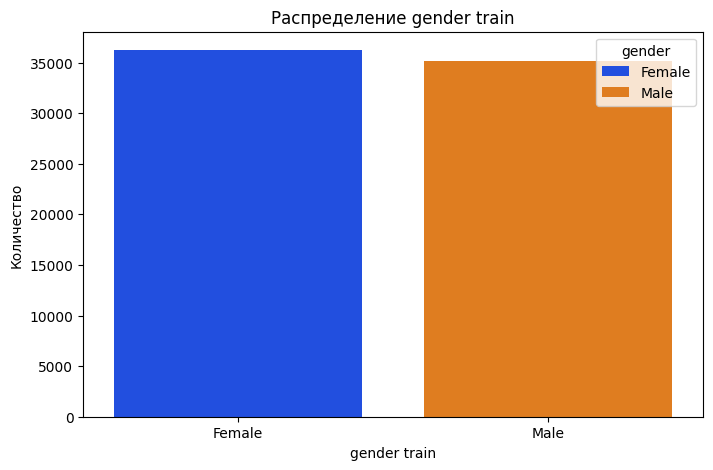

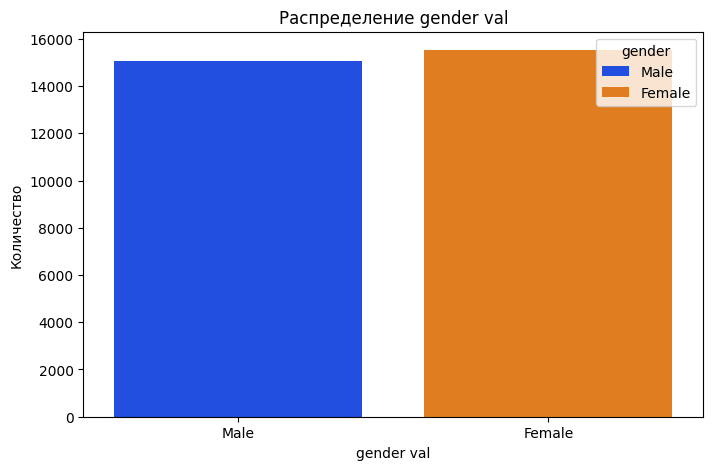

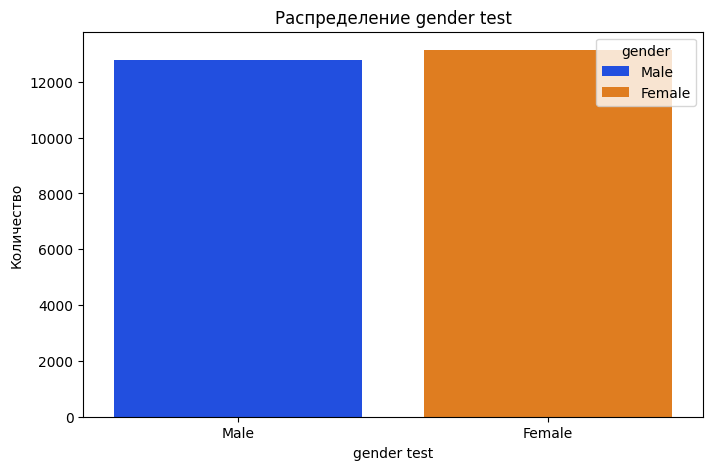

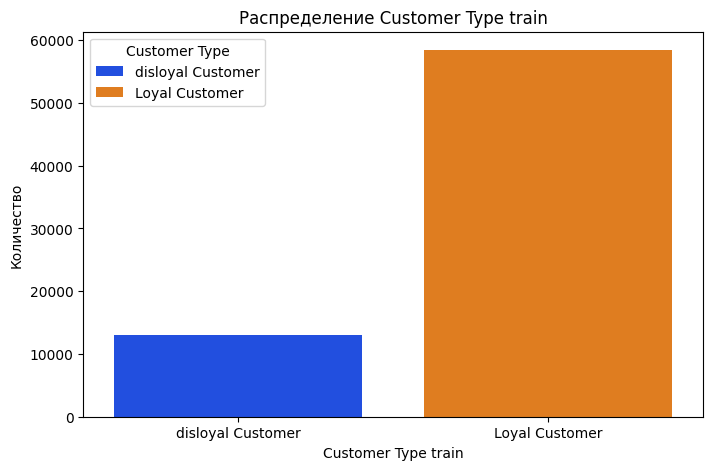

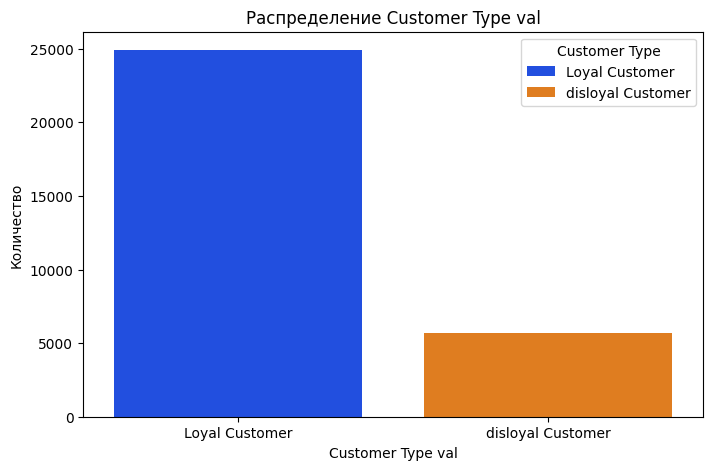

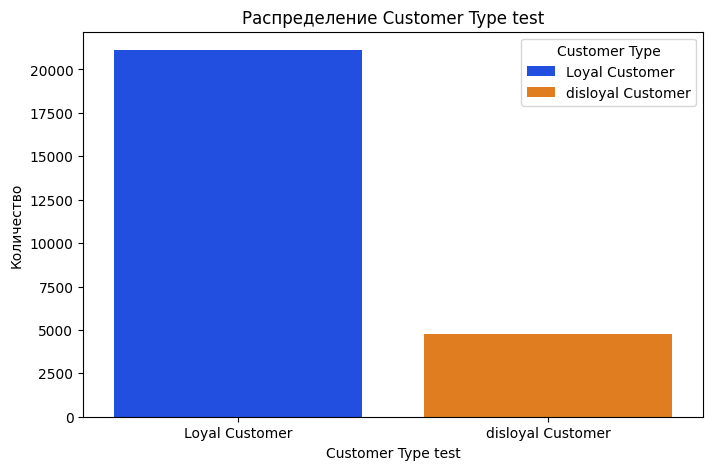

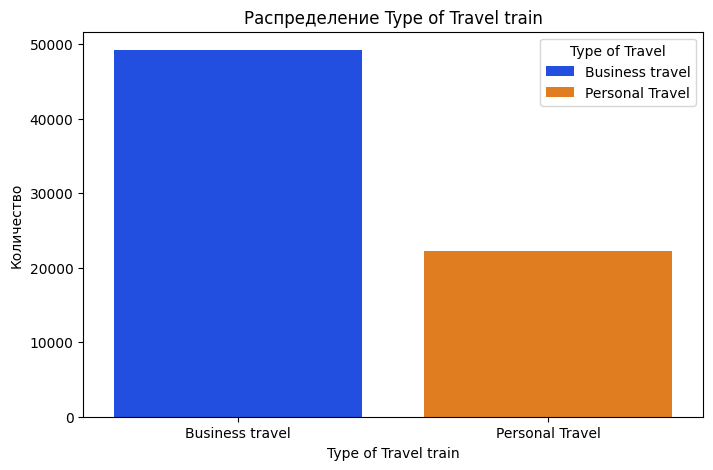

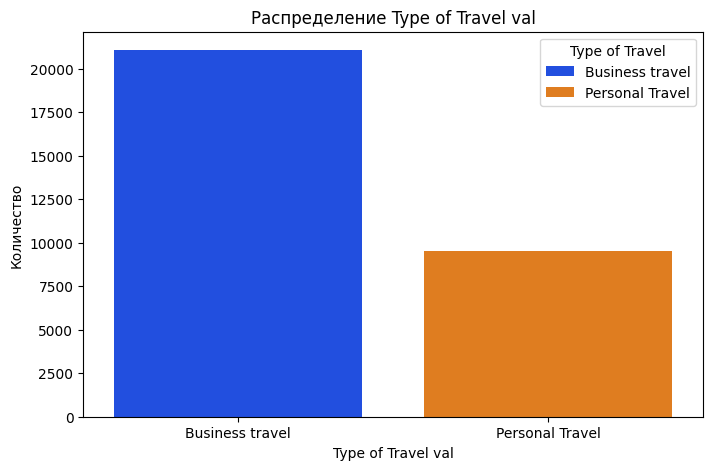

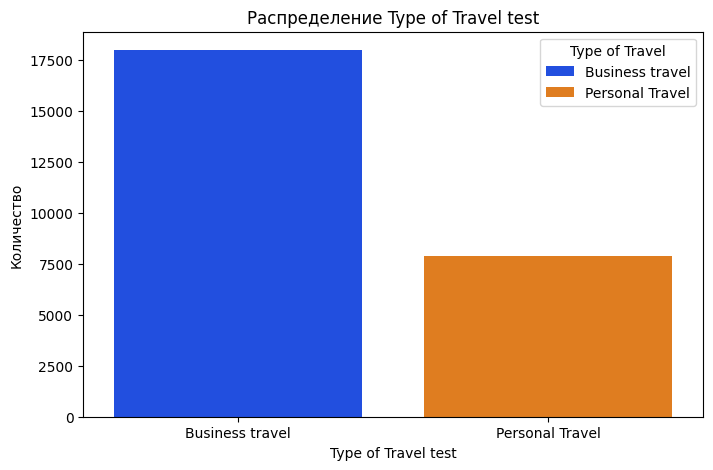

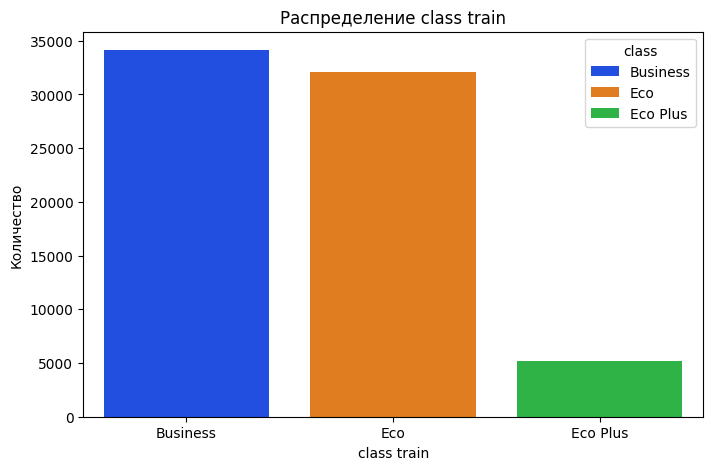

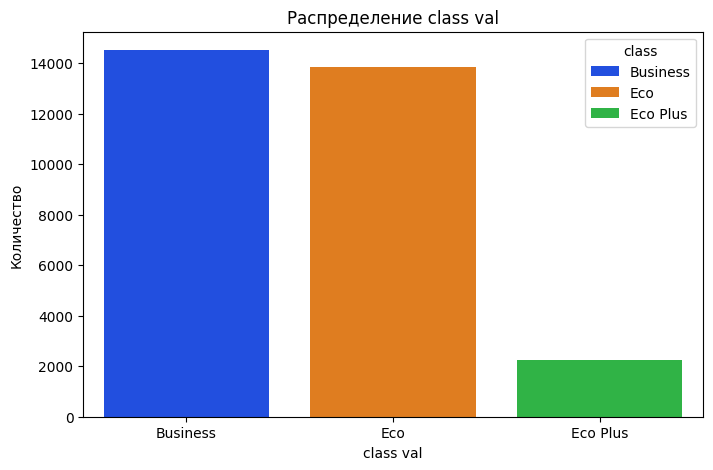

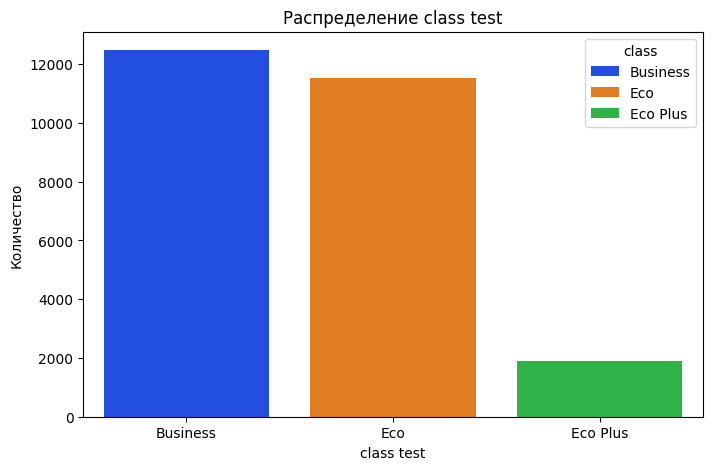

In [ ]:
for col in categorical_cols:
  class_visualization(X_train[col], f'{col} train')
  class_visualization(X_val[col], f'{col} val')
  class_visualization(df_test[col], f'{col} test')

**"Customer Type"** в тренировочной выборке **отличается** от валидационной и тестовой.

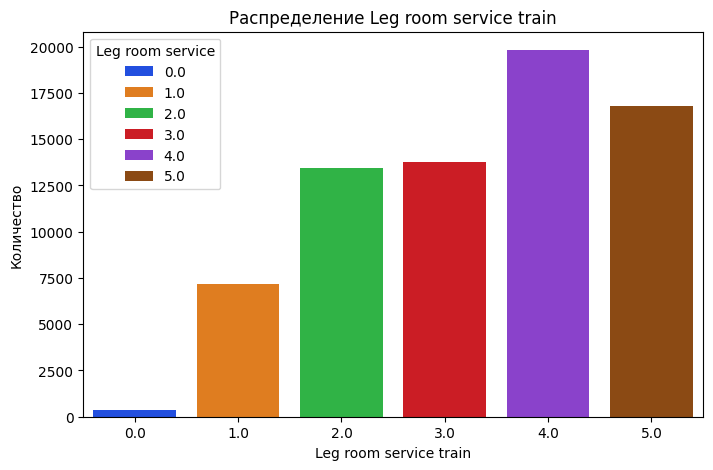

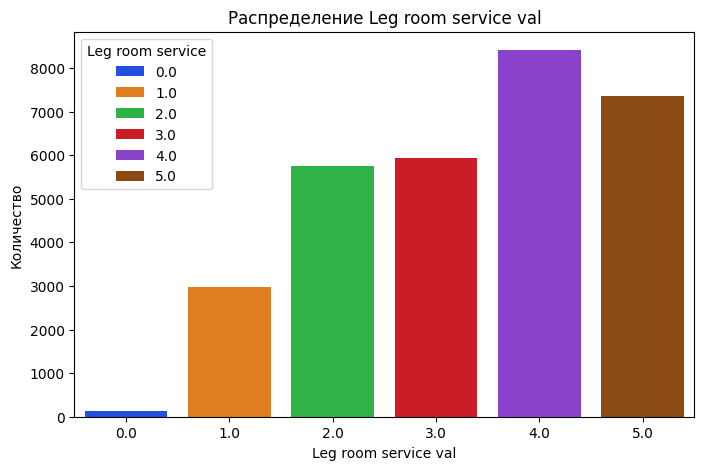

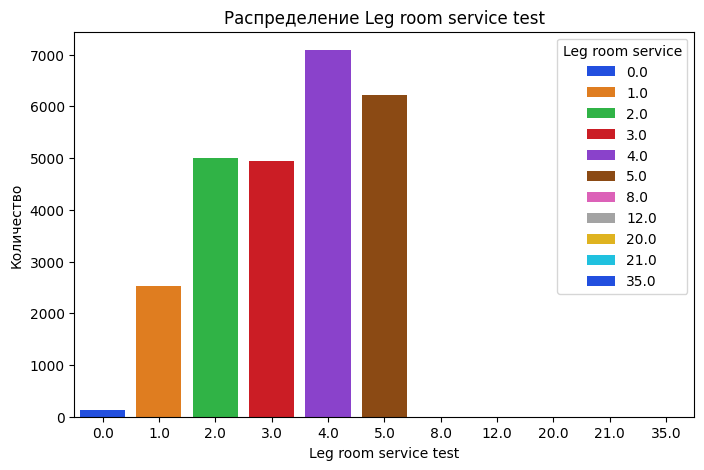

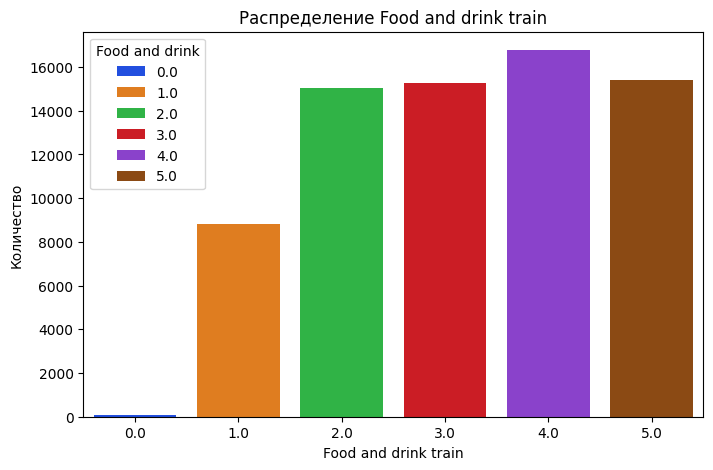

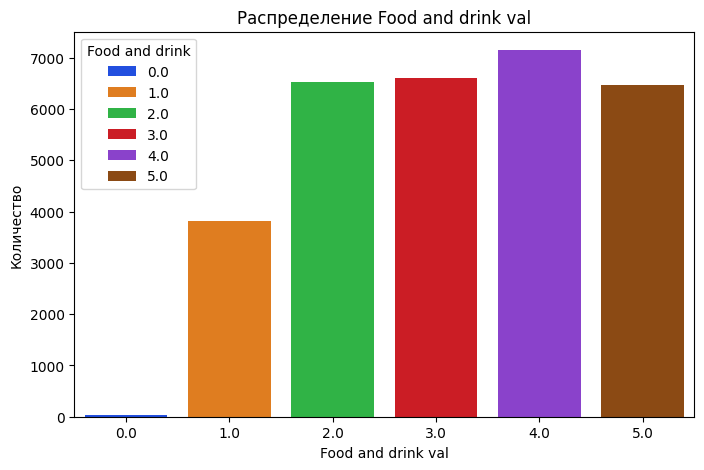

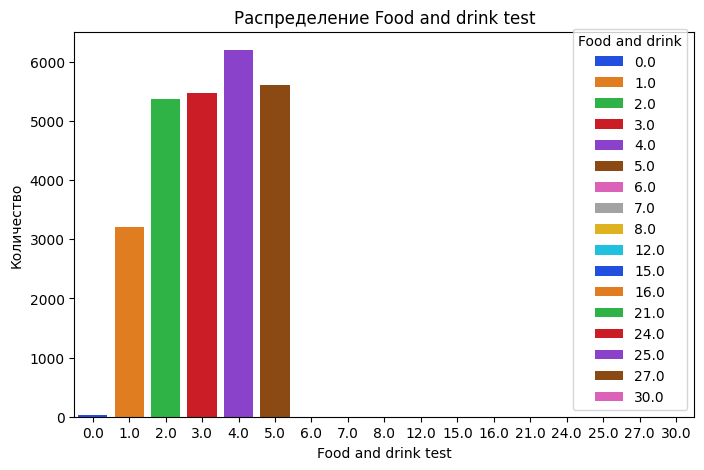

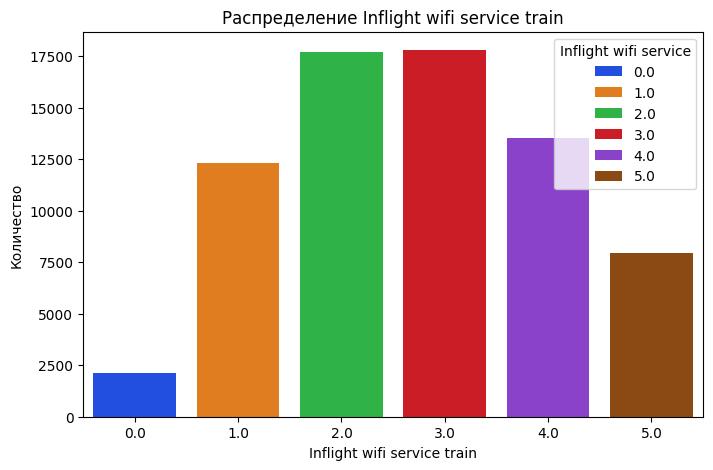

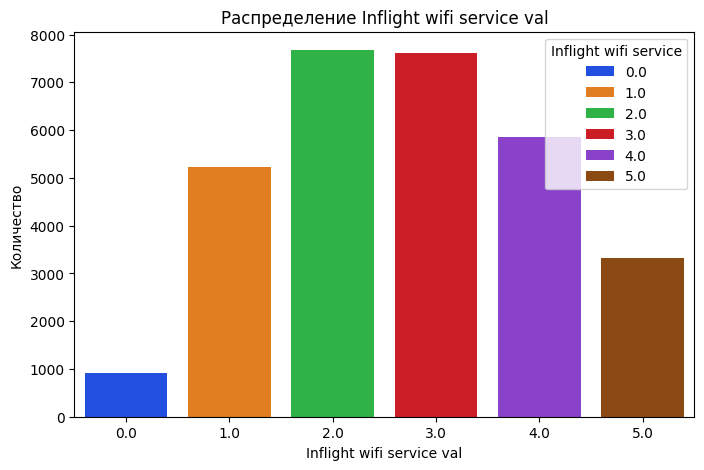

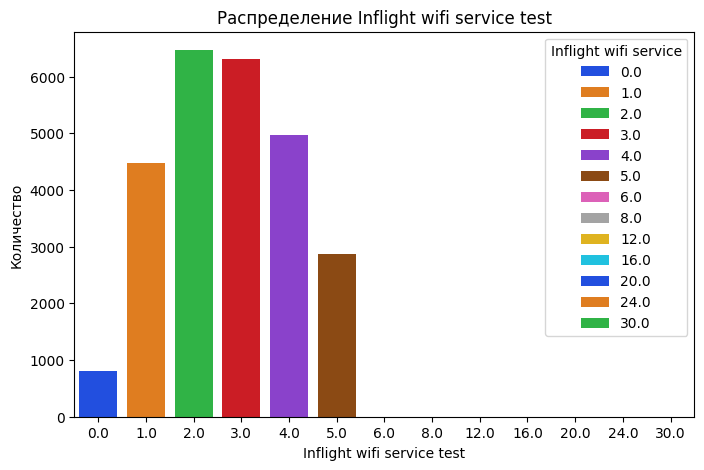

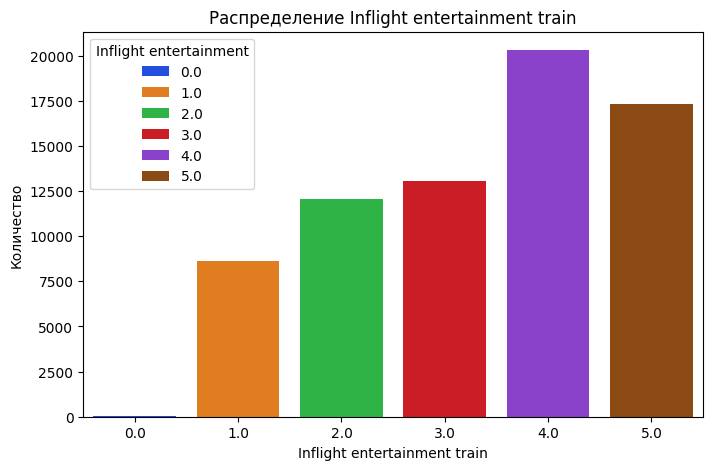

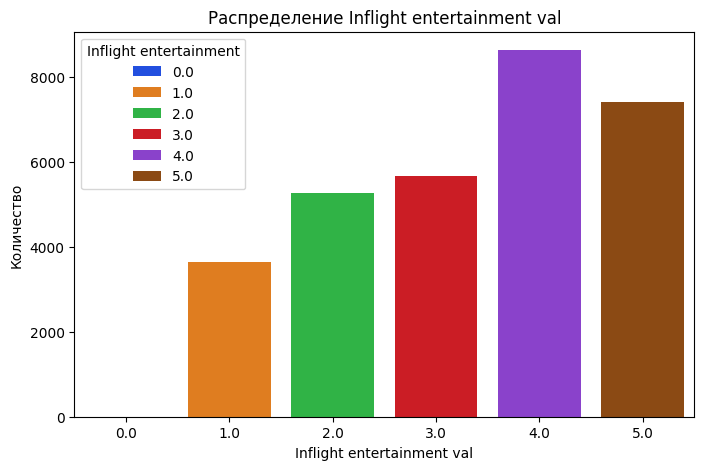

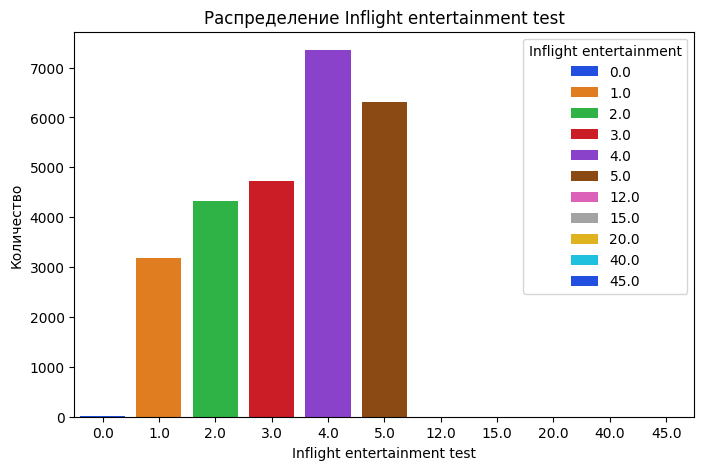

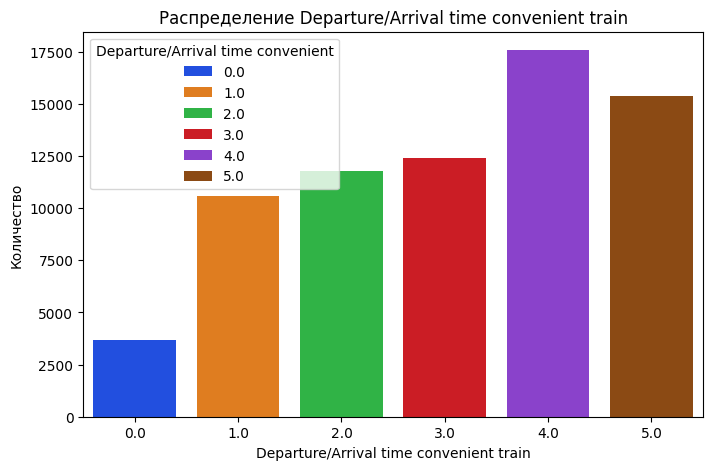

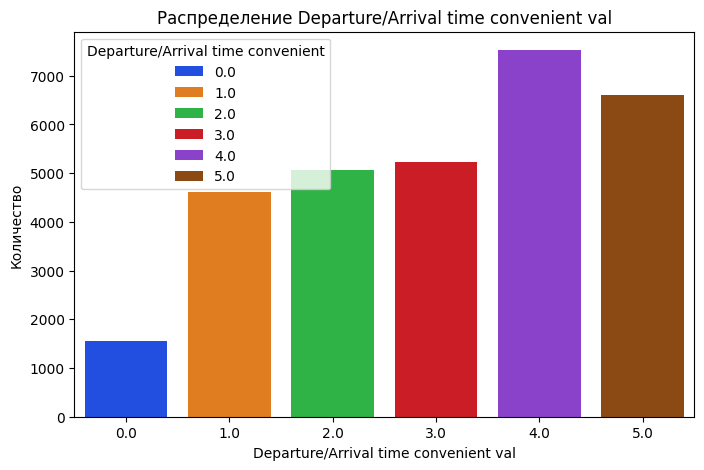

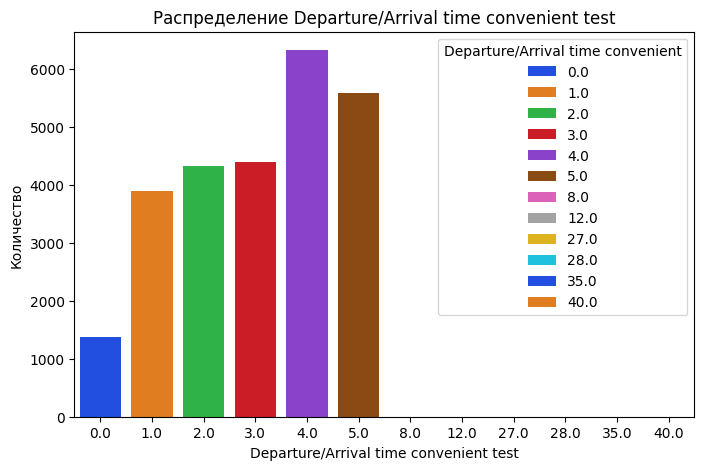

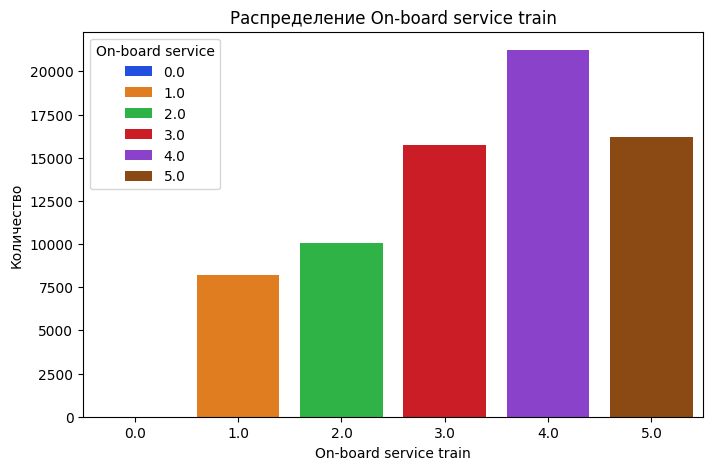

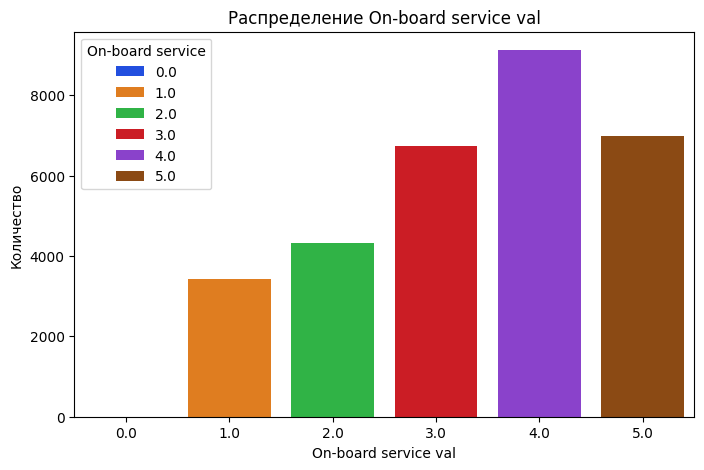

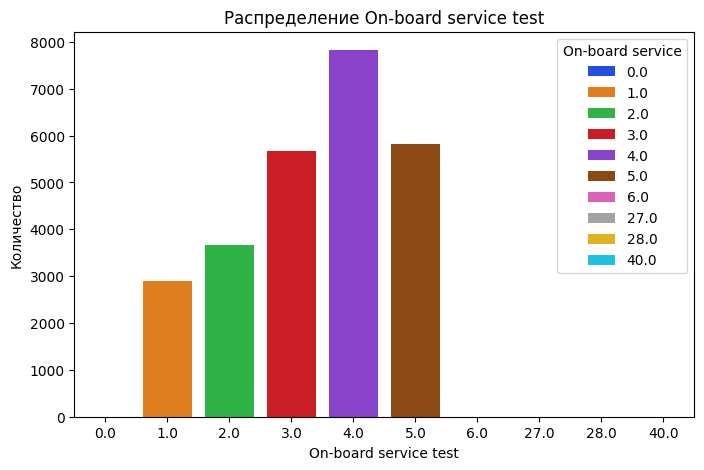

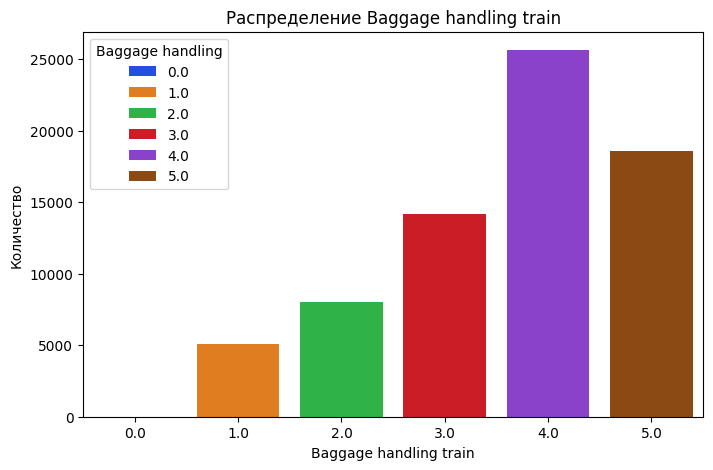

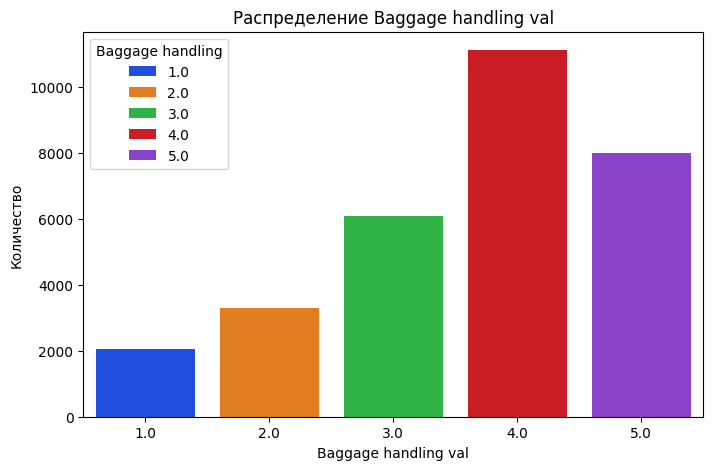

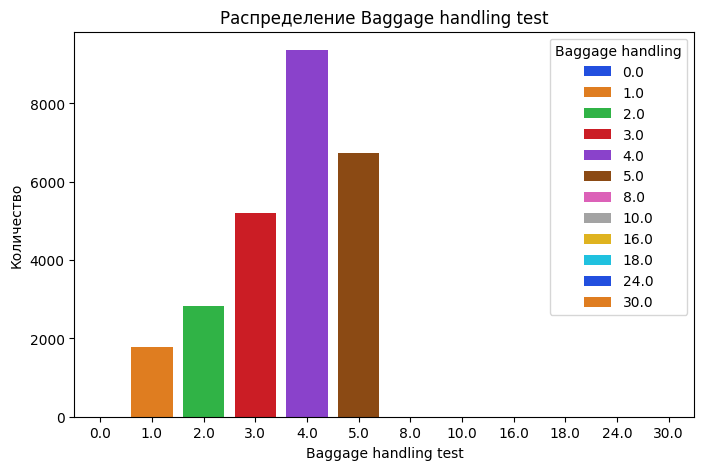

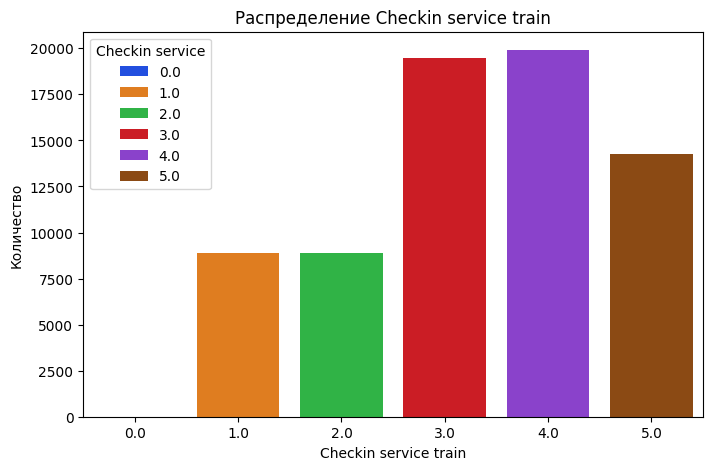

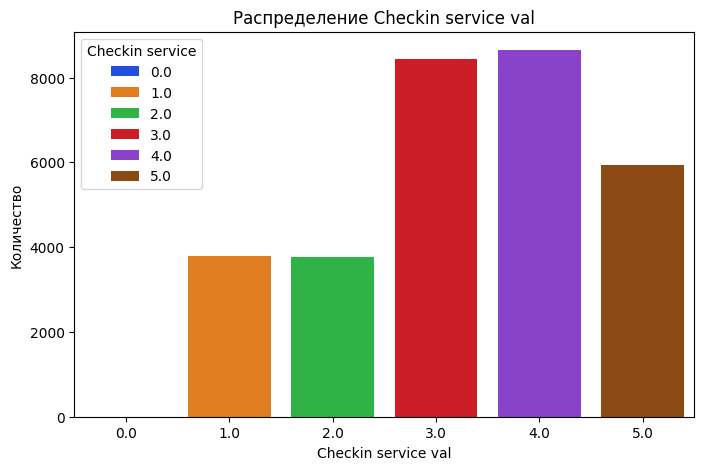

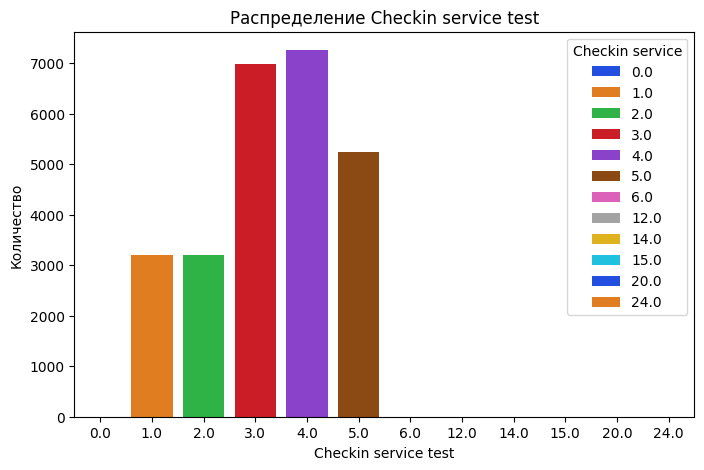

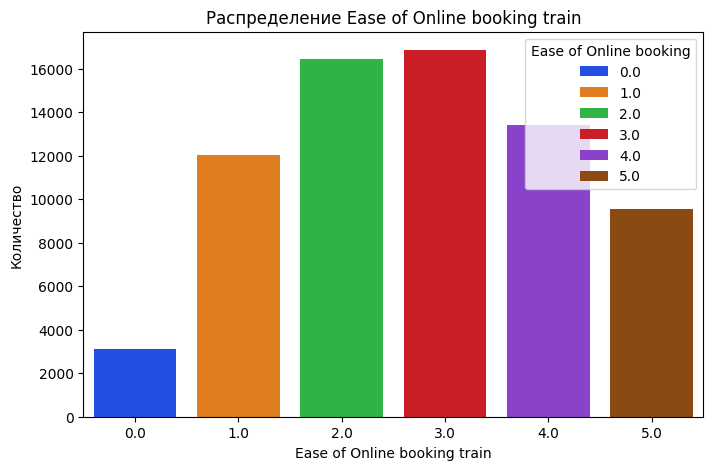

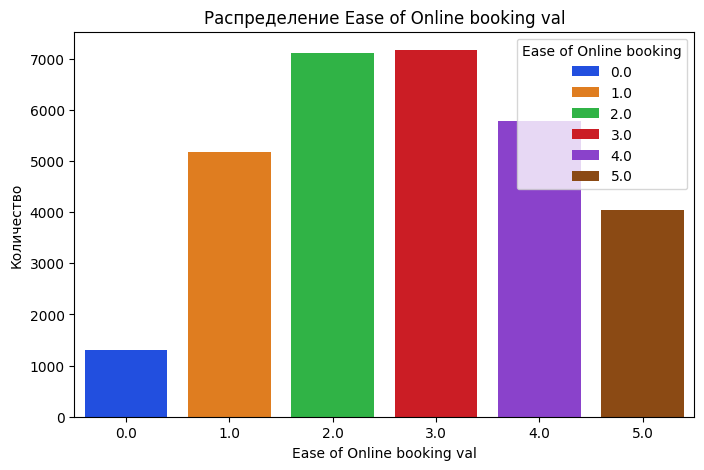

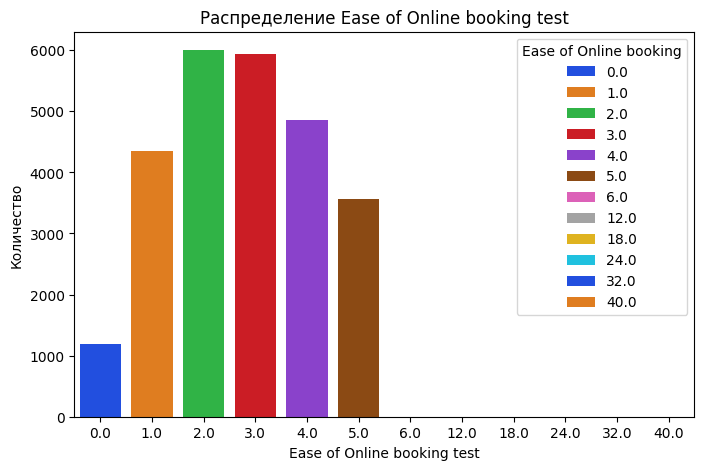

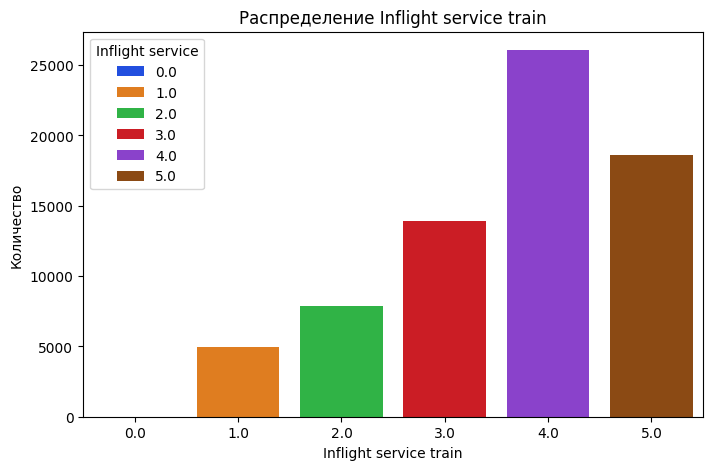

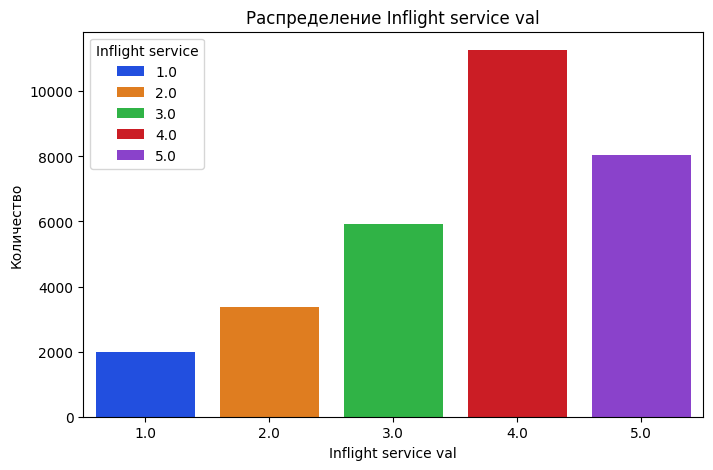

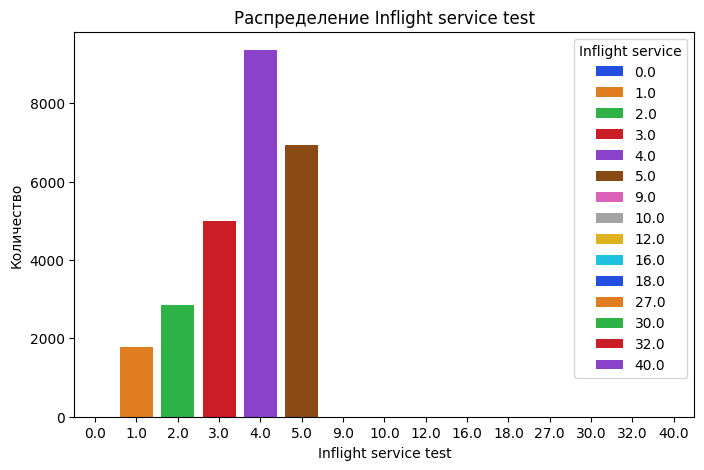

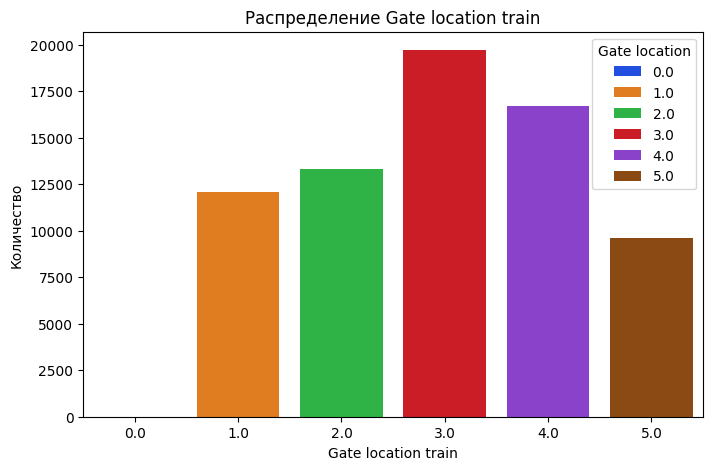

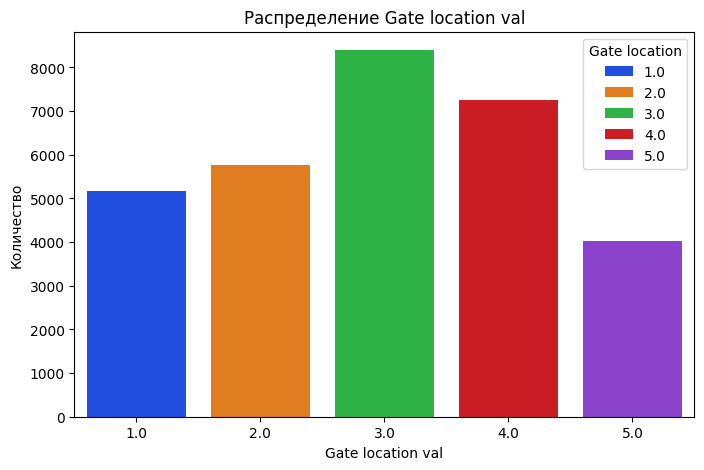

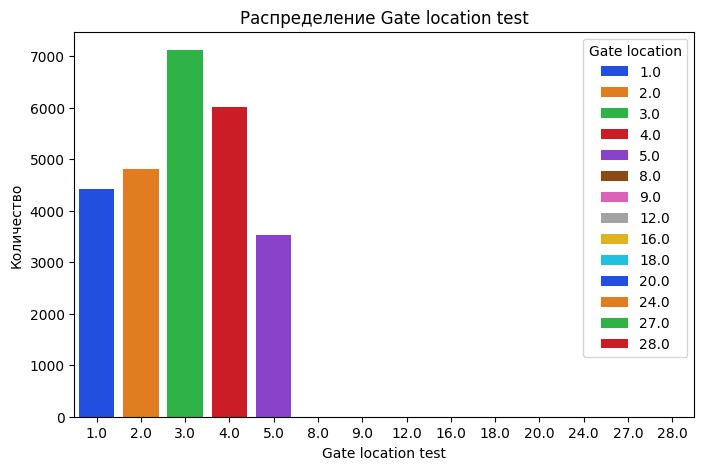

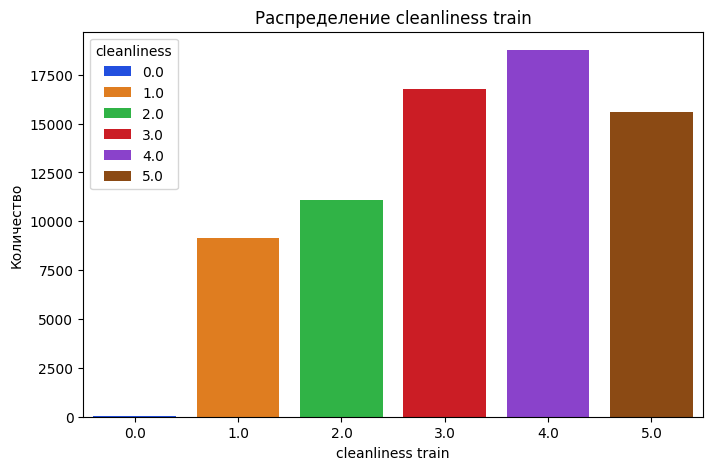

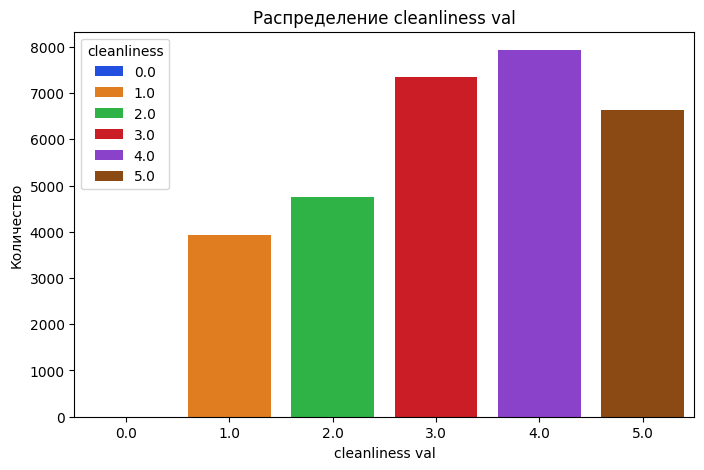

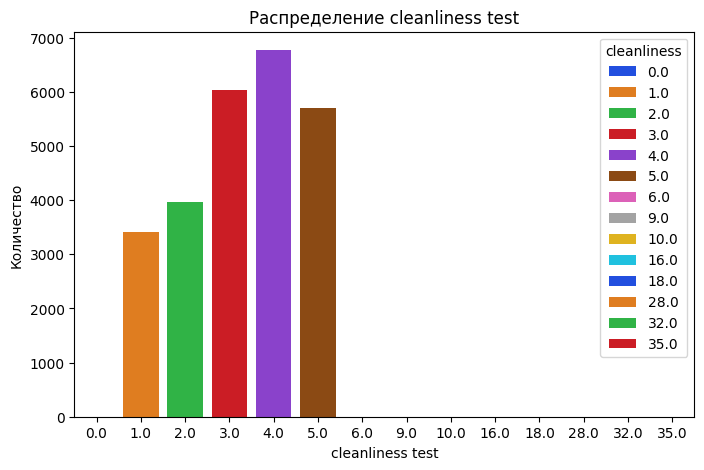

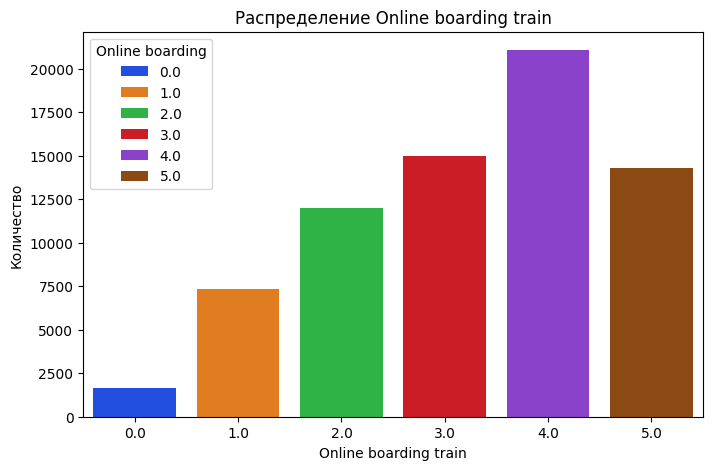

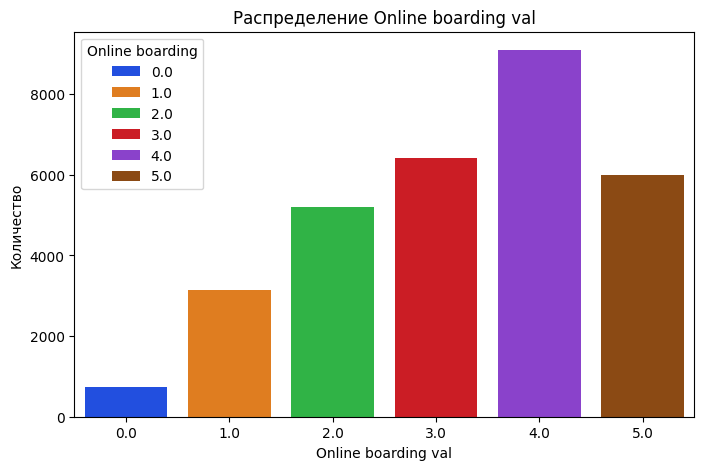

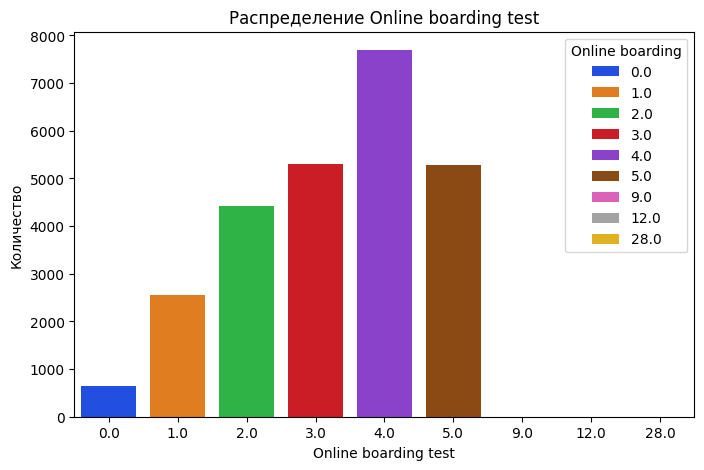

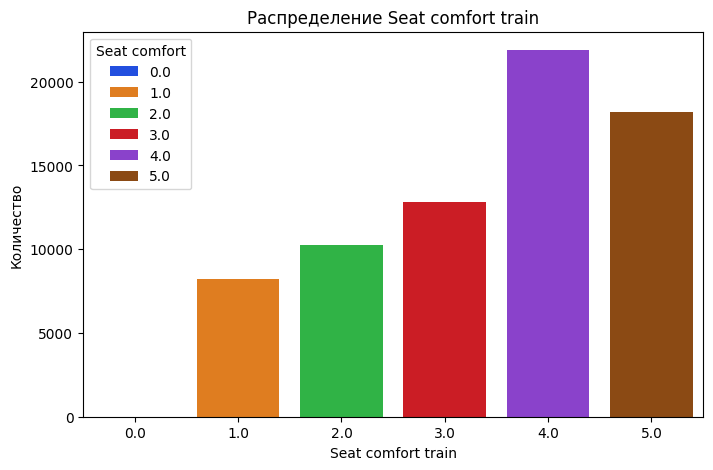

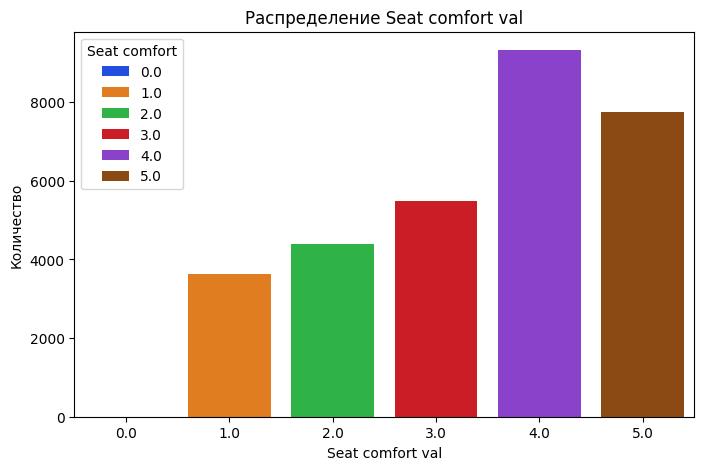

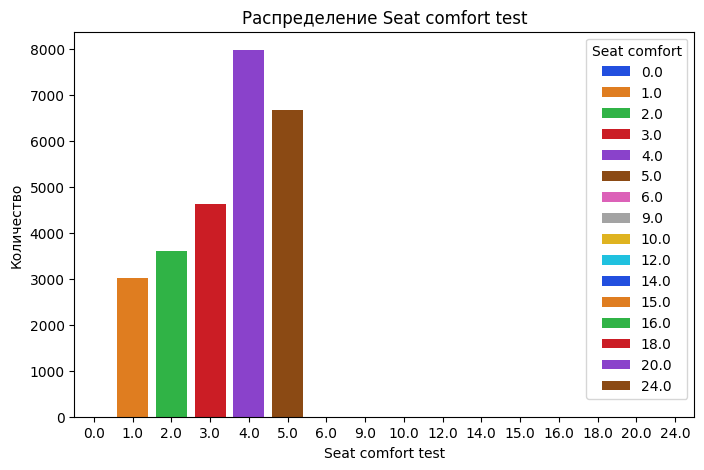

In [ ]:
for col in ordinal_cols:
  class_visualization(X_train[col], f'{col} train')
  class_visualization(X_val[col], f'{col} val')
  class_visualization(df_test[col], f'{col} test')

**Разбиение порядковых признаков похоже** во всех выборках (в тесте остались выбросы)

In [ ]:
def continuous_visualization(data, name):
  plt.subplot(1, 2, 1)
  sns.boxplot(y=data)
  plt.title(f'Ящик с усами {name}')
  plt.xlabel(name)
  plt.ylabel('Частота')
  plt.show()

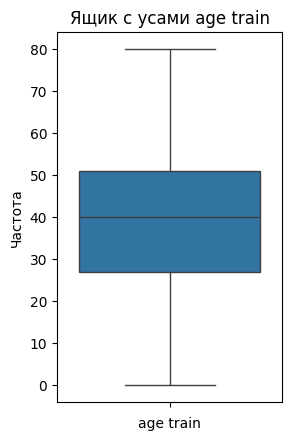

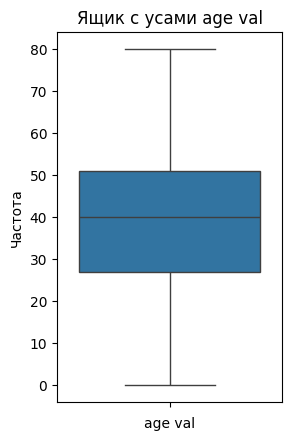

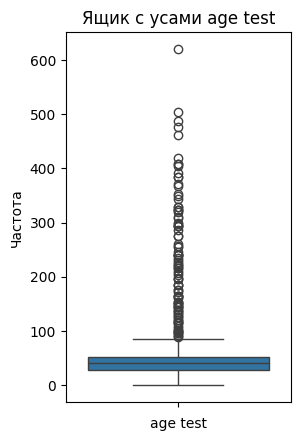

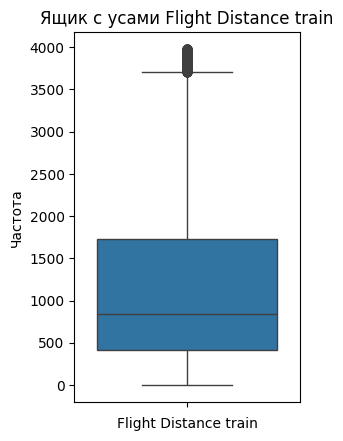

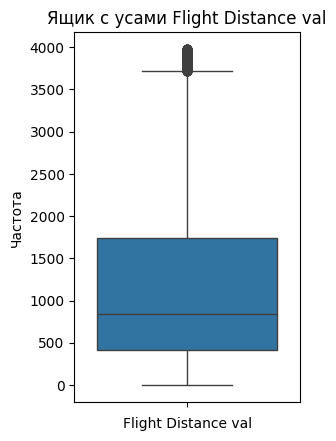

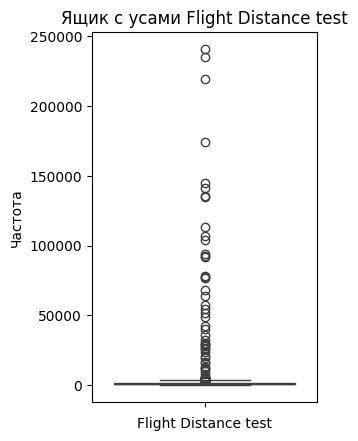

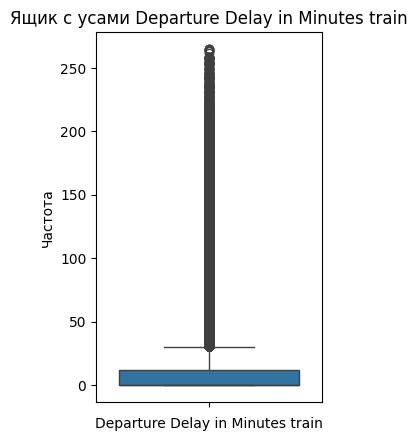

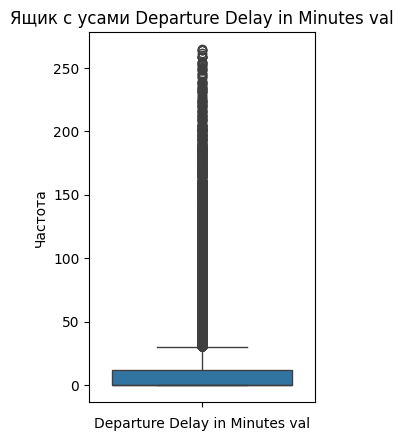

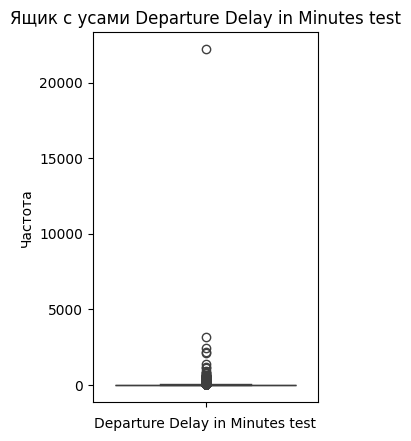

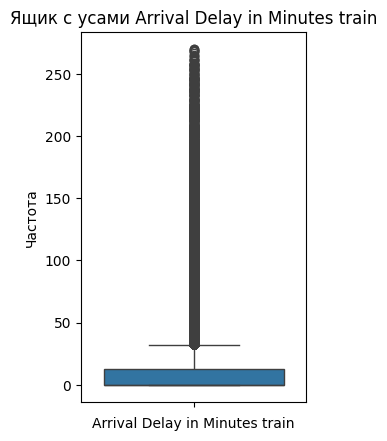

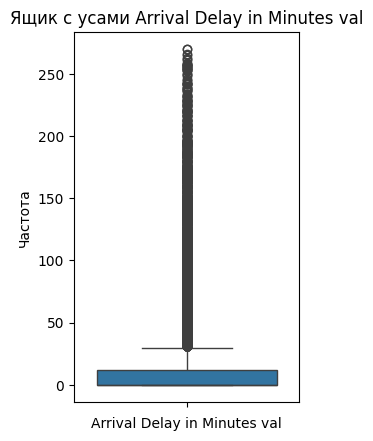

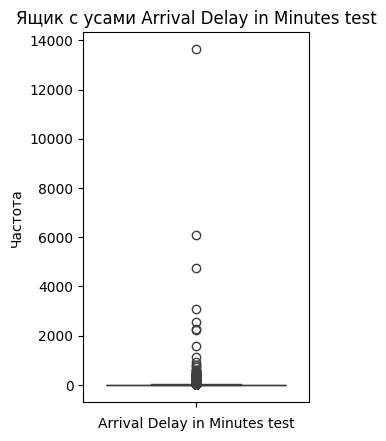

In [ ]:
for col in continuous_cols:
  continuous_visualization(X_train[col], f'{col} train')
  continuous_visualization(X_val[col], f'{col} val')
  continuous_visualization(df_test[col], f'{col} test')

**Разбиение континуальных признаков похоже** во всех выборках (в тесте остались выбросы)

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [30]:
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes'])

df_test['Departure Delay in Minutes'] = np.log1p(df_test['Departure Delay in Minutes'])
df_test['Arrival Delay in Minutes'] = np.log1p(df_test['Arrival Delay in Minutes'])

Построение.

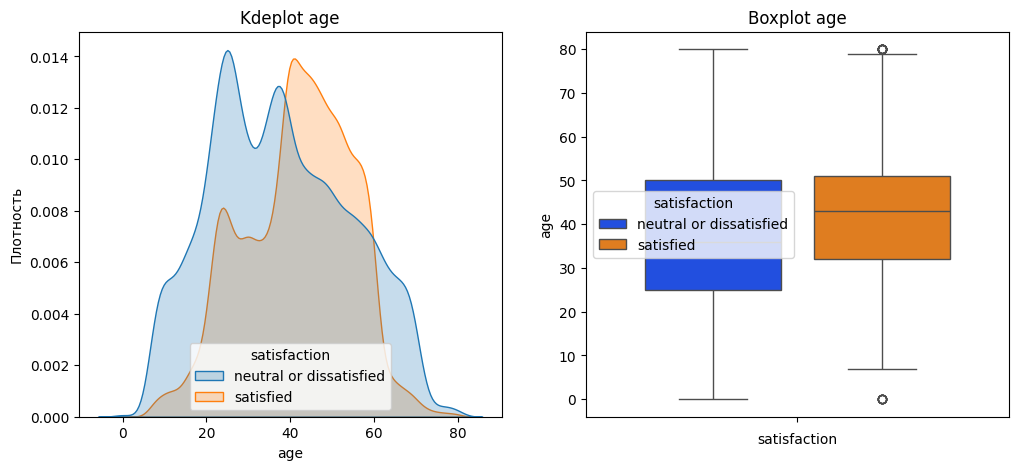

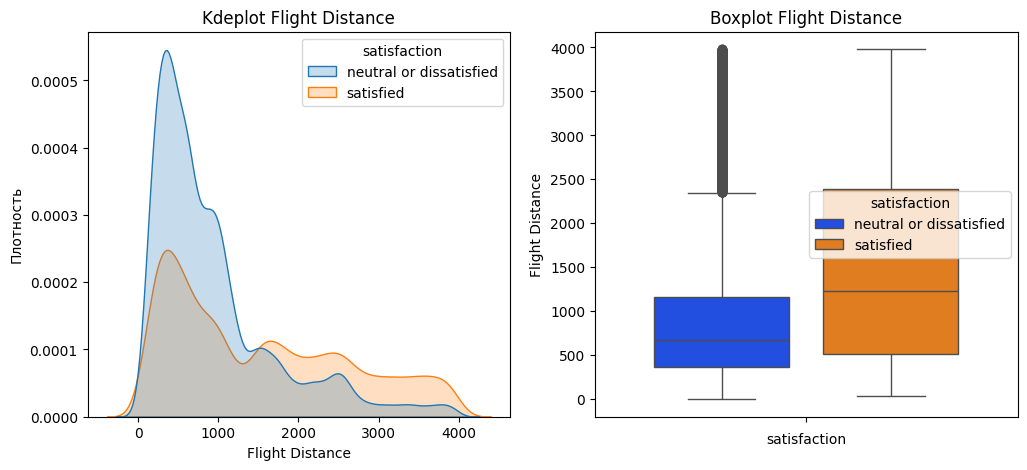

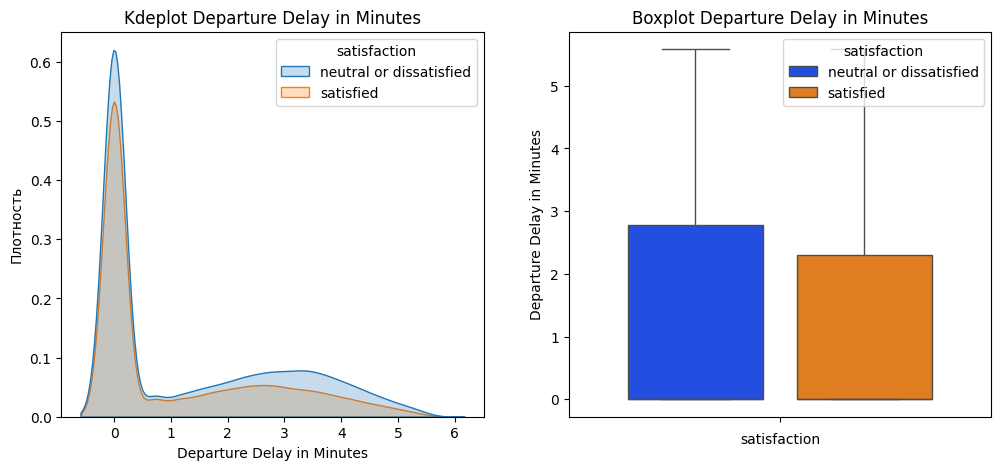

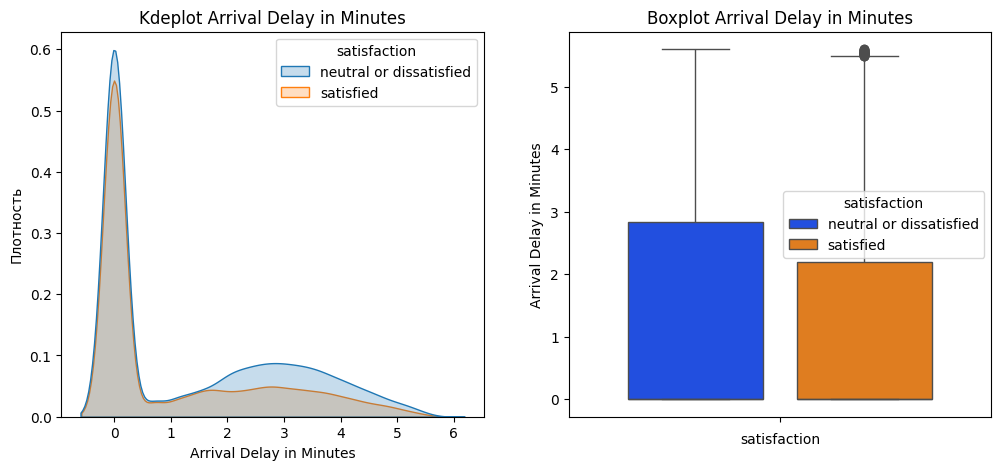

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

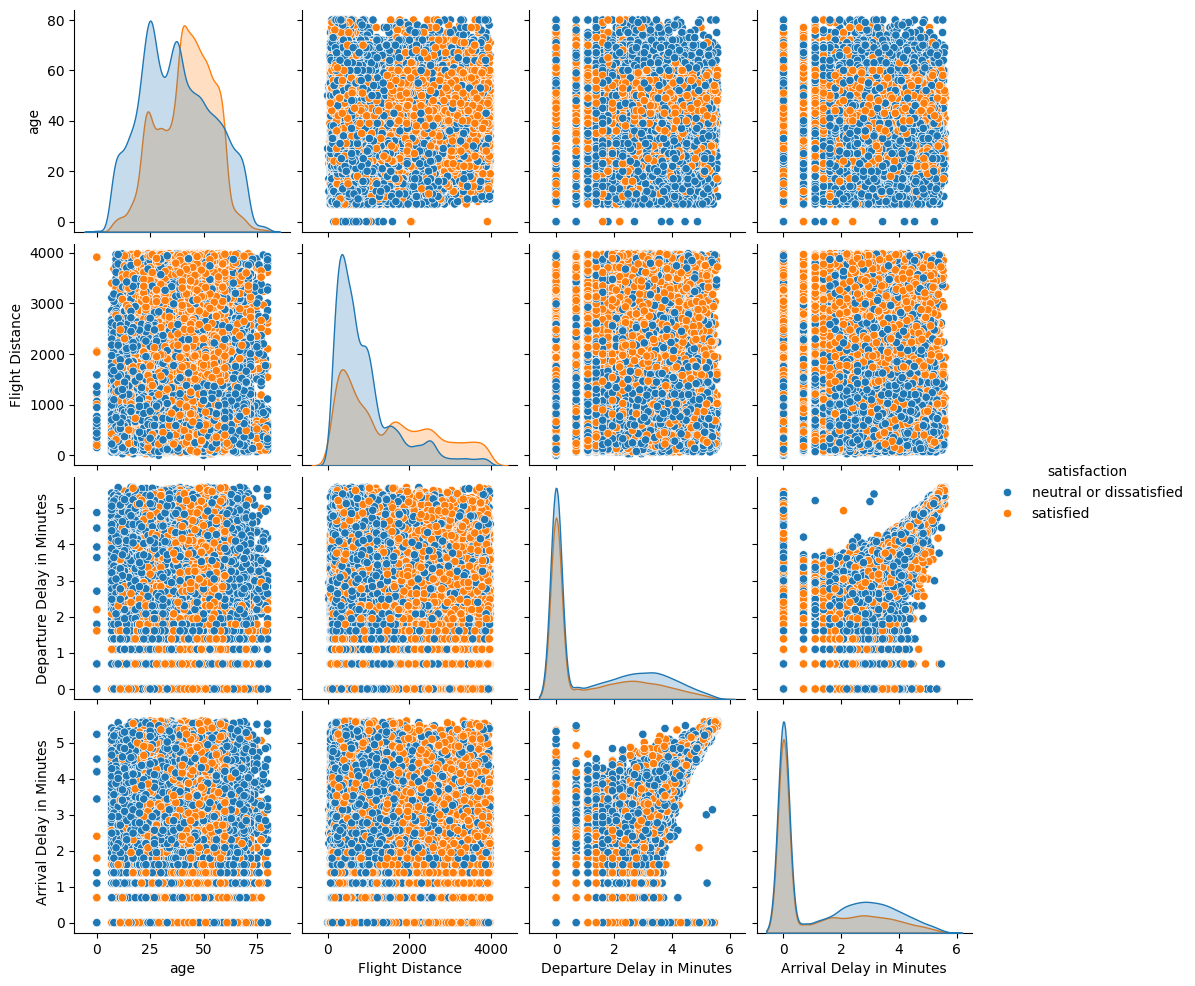

In [ ]:
pair_data = X_train[continuous_cols].copy()
pair_data['satisfaction'] = y_train
sns.pairplot(pair_data, hue='satisfaction', diag_kind='kde')
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [31]:
y_train = y_train.map(lambda y: 1 if y=='satisfied' else 0)
y_val = y_val.map(lambda y: 1 if y=='satisfied' else 0)

В каждой выборке представлены все категории, поэтому можно сделать drop_first

In [32]:
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=int)
X_val_enc = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True, dtype=int)

In [33]:
df_test_enc = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True, dtype=int)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train_enc, y_train)
pred = tree.predict(X_val_enc)

accuracy_score(y_val, pred)

0.942843137254902

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp(
    tree,
    X_train=X_train_enc.values,
    y_train=y_train.values,
    X_test=X_val_enc.values,
    y_test=y_val.values,
    loss='0-1_loss',
    random_seed=42
    )
error_dt, bias_dt, var_dt

(0.06187352941176471, 0.040947712418300655, 0.046156209150326796)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
tree.tree_.max_depth

31

**Глубина дерева 31**

In [ ]:
tree.tree_.n_leaves

2095

**2095 листьев в дереве**

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

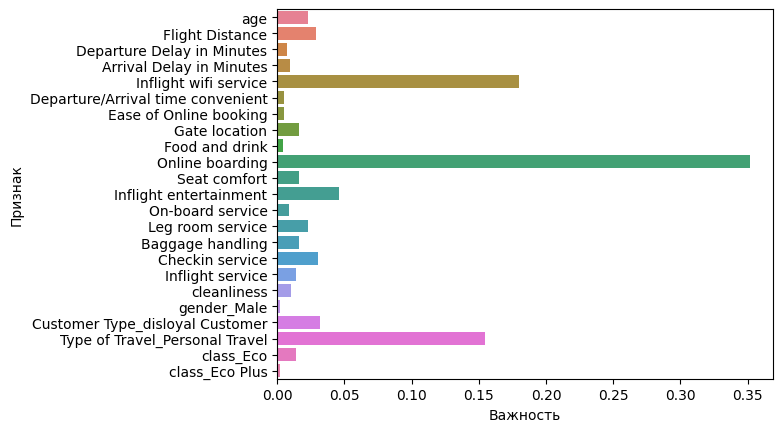

In [ ]:
fi_df = pd.DataFrame({'feature':X_train_enc.columns, 'score_DT':tree.feature_importances_})
sns.barplot(data=fi_df, x='score_DT', y='feature', hue='feature')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

**Наиболее информативные признаки:** Online boarding, Inflight wifi service,  Type of Travel

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train_enc[['Online boarding', 'Inflight wifi service']], y_train)
pred = dt.predict(X_val_enc[['Online boarding', 'Inflight wifi service']])
accuracy_score(y_val, pred)

0.8248366013071895

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

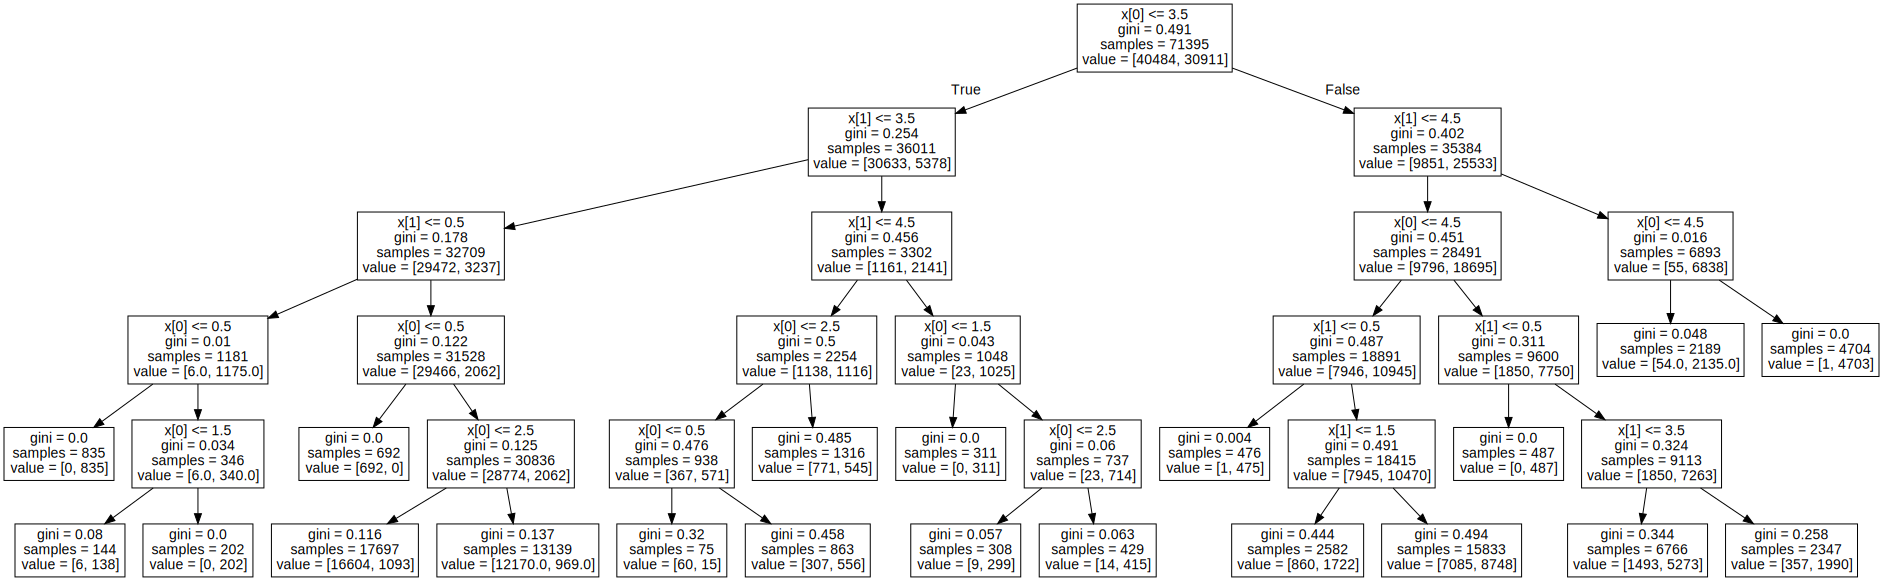

In [ ]:
gr = export_graphviz(dt)
Source(gr)

https://education.yandex.ru/handbook/ml/article/reshayushchiye-derevya#istoricheskaya-spravka
> в библиотеке sklear реализована оптимизированная версия **CART**

https://habr.com/ru/articles/801515/  
**Пороговые значения для разделения вычисляются как среднее между соседними значениями в отсортированных данных**, поэтому предикаты кратны 1/2

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

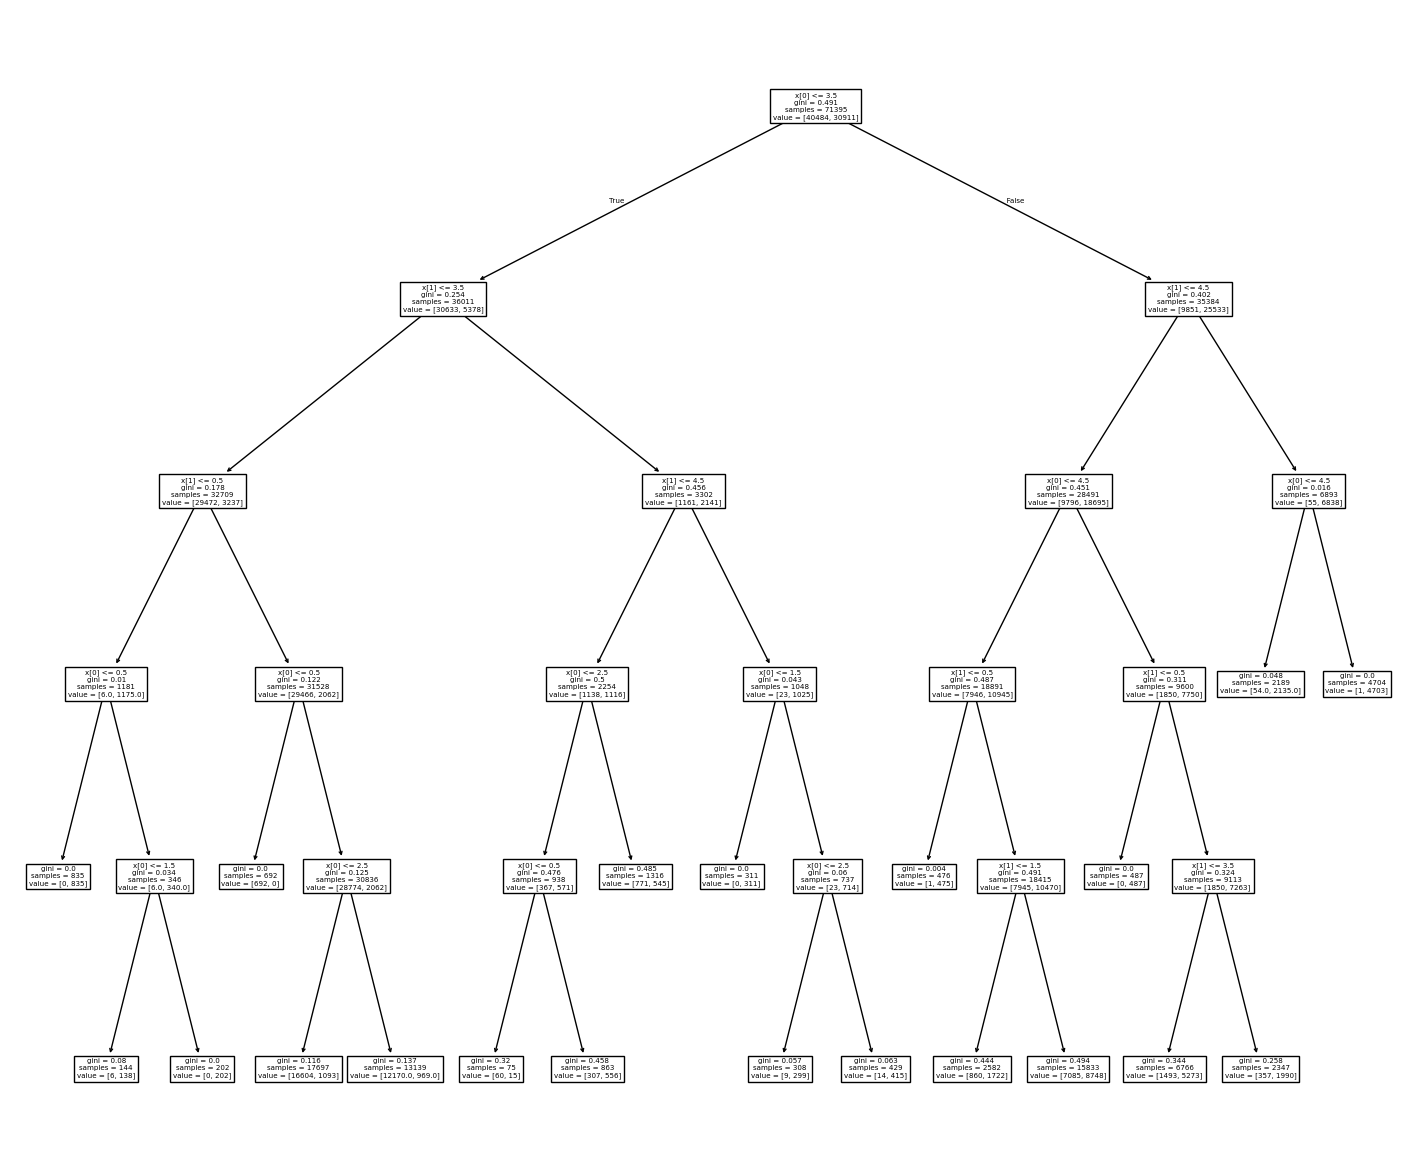

In [ ]:
plt.figure(figsize=(18, 15))
plot_tree(dt)
plt.show()

Дерево несимметричное. Если бы дерево было симметричным с ним бы было удобнее работать, т.к. оно удобнее хранится в памяти компьютера. Несимметричные деревья более склонны к переобучению, чем симметричные.

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


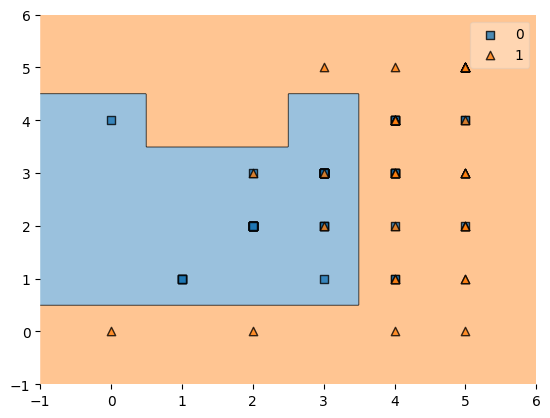

In [ ]:
plot_decision_regions(X_train_enc[['Online boarding', 'Inflight wifi service']][:100].values, y_train[:100].values, clf=dt)
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

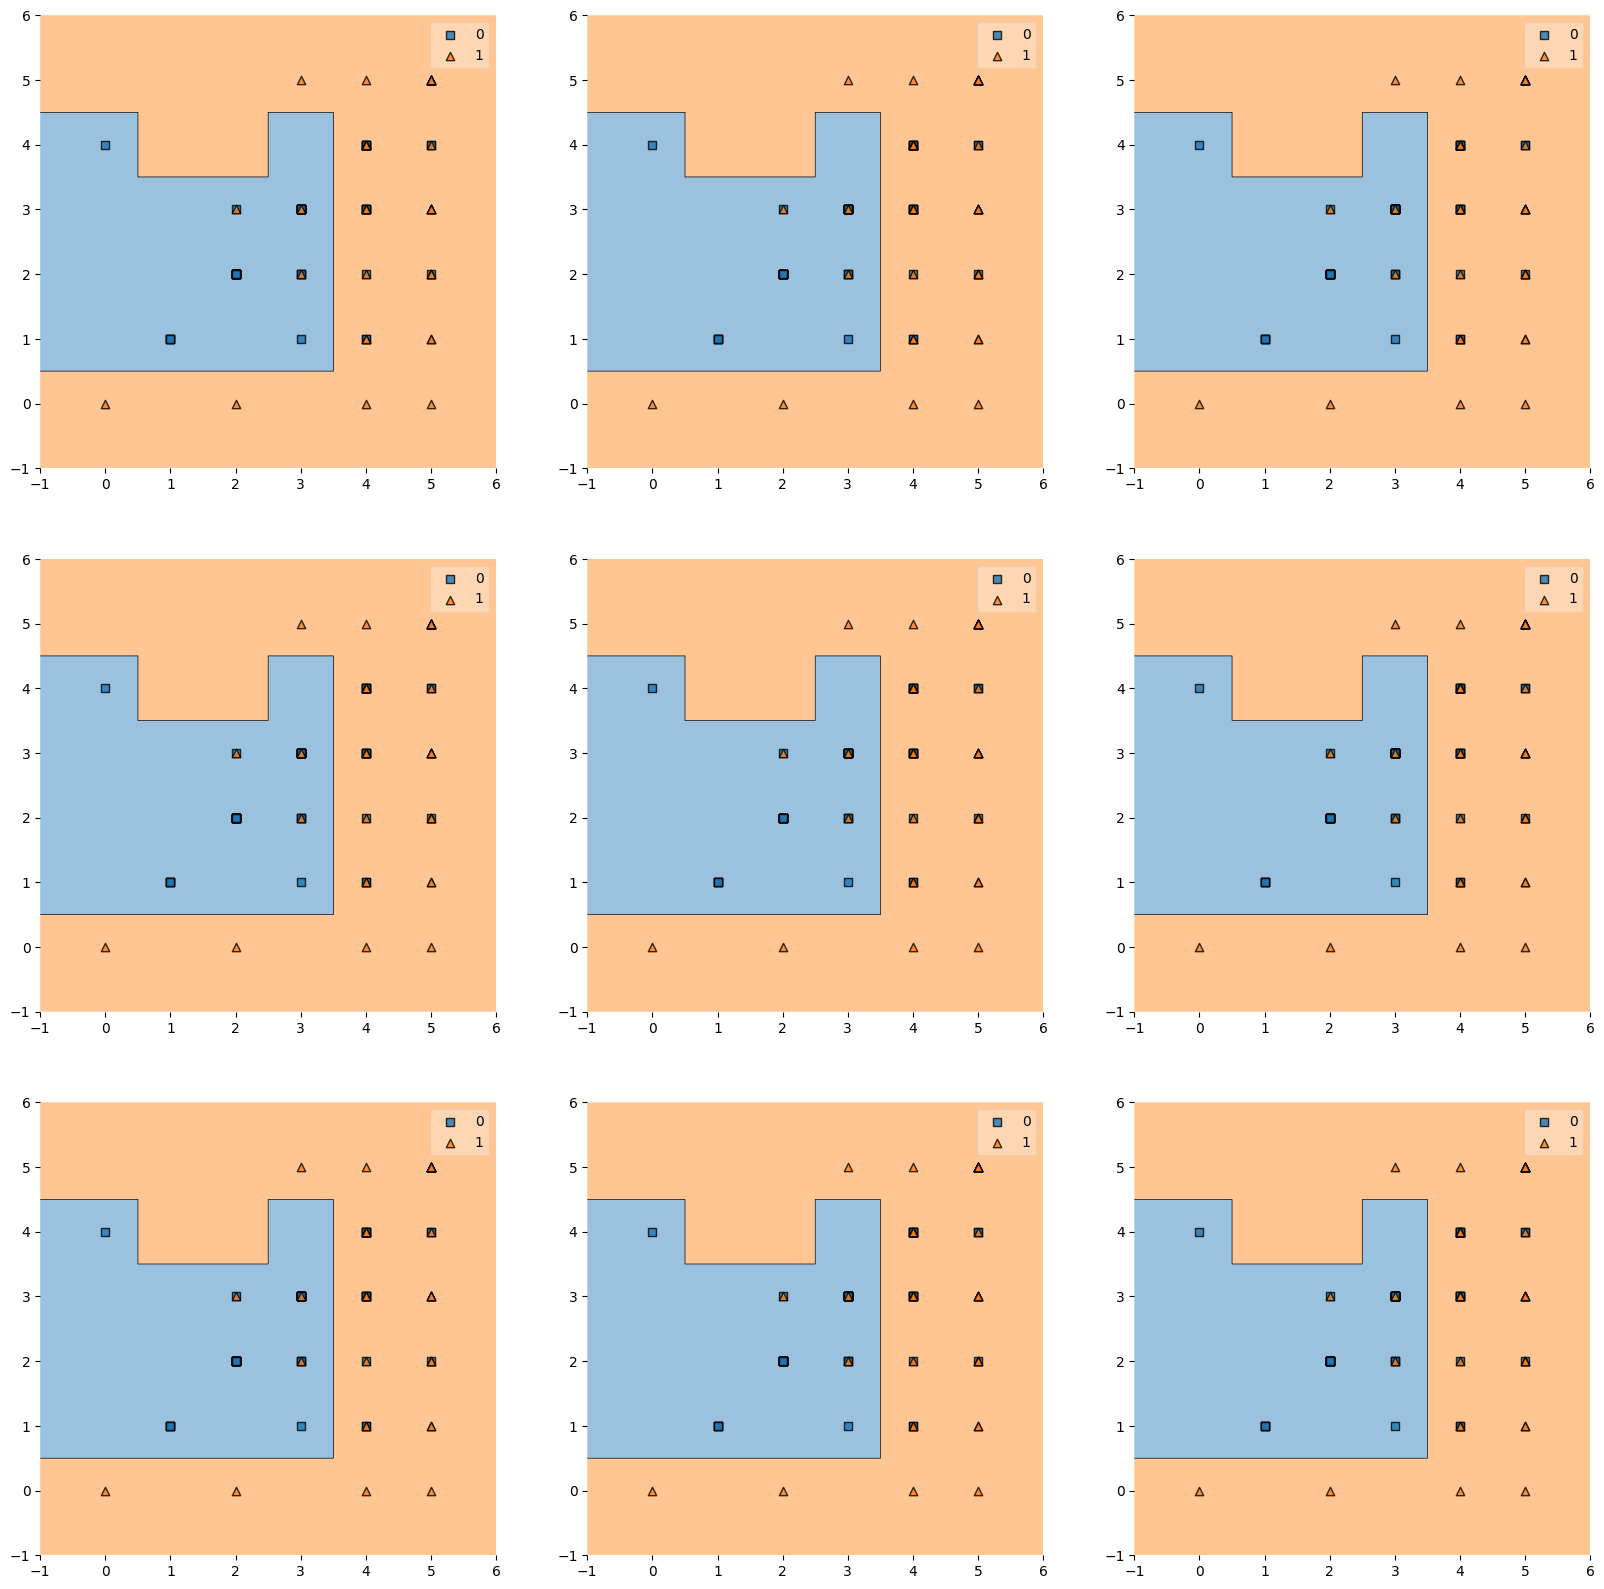

In [35]:
# замените X_train_example на вашу переменную
X_train_example = X_train_enc[['Online boarding', 'Inflight wifi service']].copy()

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

На моих признаках не видно изменения границы

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [36]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 7.47 s, sys: 14.2 ms, total: 7.49 s
Wall time: 10.6 s


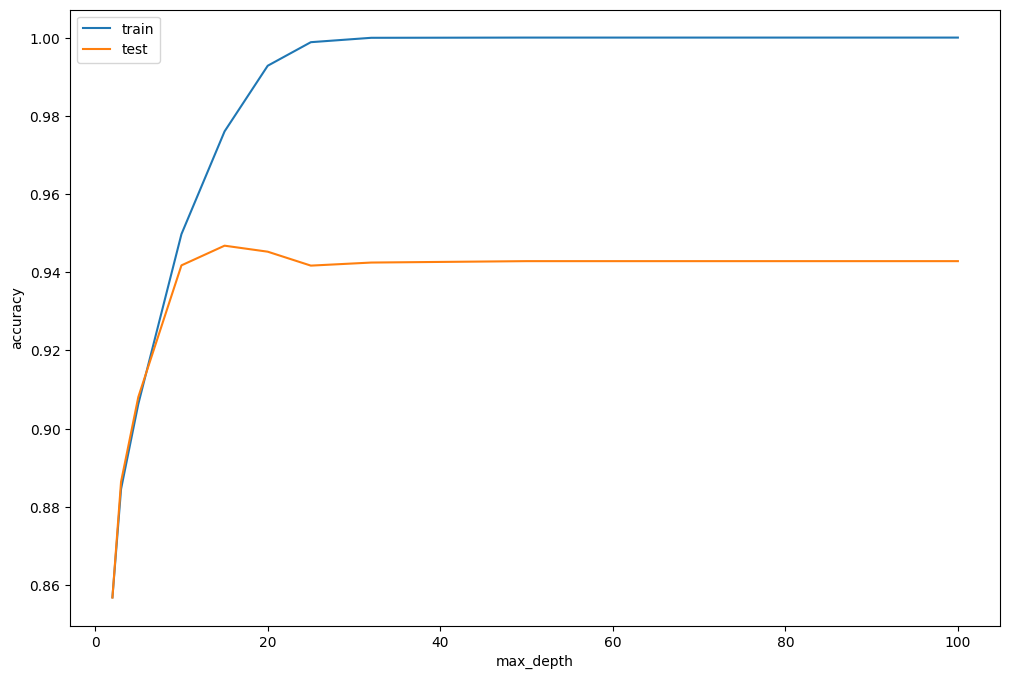

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
params={'class_weight': [None, 'balanced'], 'max_depth': [None, 5, 10, 15, 20, 30], 'min_samples_leaf':[1, 5, 10]}
dt = DecisionTreeClassifier()
model = GridSearchCV(DecisionTreeClassifier(), params, cv=3)
model.fit(X_train_enc, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10, 15, 20, 30],
                         'min_samples_leaf': [1, 5, 10]})

In [ ]:
pred = model.predict(X_val_enc)

In [ ]:
model.best_params_

{'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1}

In [ ]:
accuracy_score(y_val, pred)

0.9477450980392157

Немного удалось улучшить качество: с 0.942843137254902 до 0.9477450980392157

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as file:
    pickle.dump(model.best_estimator_, file)

In [ ]:
with open('DT.pkl', 'rb') as f:
    dt_model = pickle.load(f)

In [ ]:
dt_model

DecisionTreeClassifier(class_weight='balanced', max_depth=15)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_enc, y_train)
pred = rf.predict(X_val_enc)

In [ ]:
accuracy_score(y_val, pred)

0.9611764705882353

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

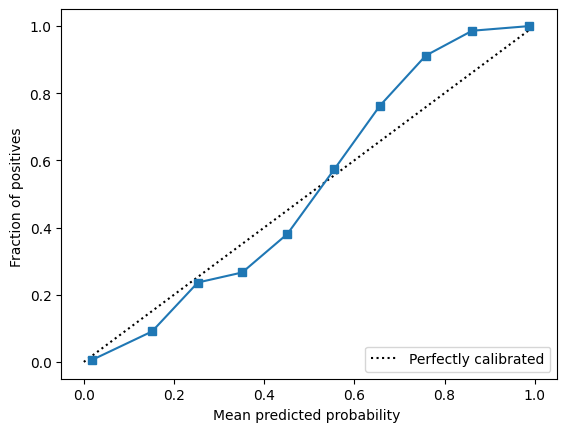

In [ ]:
# https://scikit-learn.org/1.5/modules/generated/sklearn.calibration.CalibrationDisplay.html - взято из примера
from sklearn.calibration import calibration_curve

def show_calibration(y_prob):
  prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=10)
  disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
  disp.plot()

rf_y_prob = rf.predict_proba(X_val_enc)[:, 1]
show_calibration(rf_y_prob)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Деревья склонны к сильному переобучению, что дает не совсем корректное предсказание вероятности (предсказания будут ближе к 0 или к 1). RandomForest справляется с переобучением лучше DecisionTree, но все еще может давать вероятности близкие к 0 или 1

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_enc, y_train)

LogisticRegression(max_iter=5000)

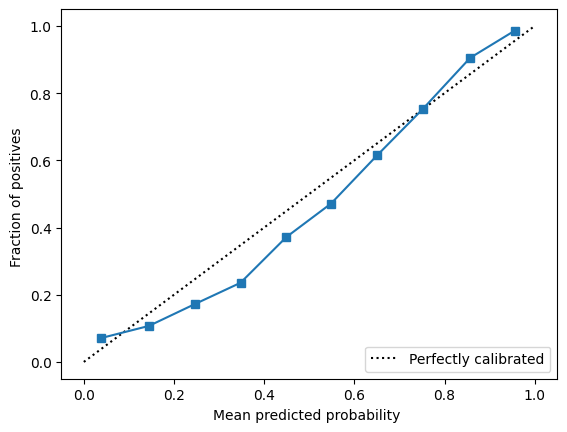

In [ ]:
lr_y_prob = lr.predict_proba(X_val_enc)[:, 1]
show_calibration(lr_y_prob)

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Логистическая регрессия **предсказывает** не классы, а **вероятности классов**. Для предсказания вероятности в логистической регрессии **используется сигмоида**.

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

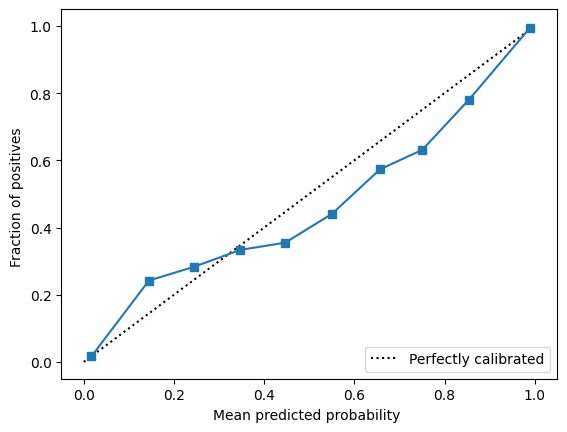

In [ ]:
logreg_model = CalibratedClassifierCV(rf, method='sigmoid', cv=3)
logreg_model.fit(X_train_enc, y_train)

logreg_model_prob = logreg_model.predict_proba(X_val_enc)[:, 1]
show_calibration(logreg_model_prob)

Калибровка с помощью логистической регрессии не дала хороший результат. Откалиброванный результат получился слишком уверенный.

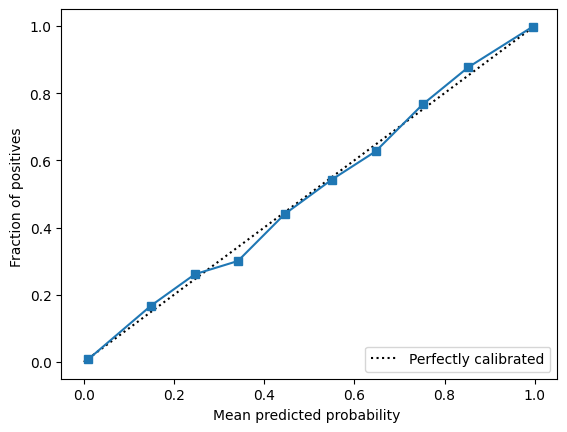

In [ ]:
isoreg_model = CalibratedClassifierCV(rf, method='isotonic', cv=3)
isoreg_model.fit(X_train_enc, y_train)

isoreg_model_prob = isoreg_model.predict_proba(X_val_enc)[:, 1]
show_calibration(isoreg_model_prob)

Калибровка с помощью изотонической регрессии показала хороший результат. Откалиброванные значения близки к идеальной диагонали.

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

[Как оценивать вероятности (Яндекс Образование)](https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti)  
[Проблема калибровки уверенности (КвазиНаучный блог Александра Дьяконова)](https://alexanderdyakonov.wordpress.com/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/)

* **Гистограммная калибровка** - Мы разбиваем отрезок [0,1] на бины $B_1,…,B_k$
  (одинаковой ширины или равномощные) и хотим на каждом из них предсказывать всегда одну и ту же вероятность: $θ_j$, если $q(x_i) ∈ B_j$. Вероятности $θ_i$
  подбираются так, чтобы они как можно лучше приближали средние метки классов на соответствующих бинах;
* **Калибровка Платта** - Представляет собой по сути применение сигмоиды поверх другой модели (то есть самый наивный способ получения «вероятностей»);
* **Деревья калибровки** - Стандартный алгоритм строит суперпозицию дерева на исходных признаках и логистических регрессий (каждая в своём листе) над оценками алгоритма;
* **Ансамблирование** - Метод, который осуществляет комбинация нескольких биннингов (равномощных) с разным числом бинов. Ответ ищется в виде линейной комбинации оценок бинингов с весами, применяется байесовское усреднение;
* и т.д.

### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
error_rf, bias_rf, var_rf = bias_variance_decomp(
    rf,
    X_train=X_train_enc.values,
    y_train=y_train.values,
    X_test=X_val_enc.values,
    y_test=y_val.values,
    loss='0-1_loss',
    random_seed=42
    )
error_rf, bias_rf, var_rf

(0.040787745098039216, 0.03934640522875817, 0.009153431372549021)

Для дерева решений: bias = 0.040947712418300655, variance = 0.046156209150326796  
Для случайного леса: bias = 0.03934640522875817, variance = 0.009153431372549021  
Для случайного леса смещение уменьшилось немного и сильно уменьшился разброс.  
Случайный лес должен сохранять смещение и уменьшать разброс, что **соответствует полученным результатам**.

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
error_lr, bias_lr, var_lr = bias_variance_decomp(
    lr,
    X_train=X_train_enc.values,
    y_train=y_train.values,
    X_test=X_val_enc.values,
    y_test=y_val.values,
    loss='0-1_loss',
    random_seed=42
    )
error_lr, bias_lr, var_lr

(0.12418333333333333, 0.12444444444444444, 0.004036928104575163)

Для дерева решений: bias = 0.040947712418300655, variance = 0.046156209150326796  
Для случайного леса: bias = 0.03934640522875817, variance = 0.009153431372549021  
Для логистической регрессии bias = 0.12444444444444444, variance = 0.004036928104575163  
В сравнении с деревом решений и случайным лесом у логистической регрессии *смещение значительно больше, а разброс сильно меньше*. Это связано с тем, что логистическая регрессия - линейная модель.
* Если зависимости в данных нелинейные, то логистическая регрессия будет иметь высокое смещение.
* По сравнению с деревьями логистическая регрессия переобучается не сильно, поэтому имеет меньший разброс

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import uniform, randint

params={
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_leaf':randint(1, 11),
    'min_samples_split': randint(2, 11),
    'n_estimators': randint(100, 501),
    'max_samples': uniform(0.5, 0.5)
    }
opt_rf = RandomizedSearchCV(RandomForestClassifier(), params, random_state=42, scoring='accuracy')

In [ ]:
opt_rf.fit(X_train_enc, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 5, 10, 15, 20, 30],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78a879bc3450>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78a879c0acd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78a879bc0610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78a879bc2d90>},
                   random_state=42, scoring='accuracy')

In [ ]:
opt_rf.best_params_

{'class_weight': None,
 'max_depth': 20,
 'max_samples': 0.7252496259847715,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 188}

In [ ]:
pred = opt_rf.predict(X_val_enc)

In [ ]:
accuracy_score(y_val, pred)

0.9588888888888889

С параметрами по умолчанию accuracy получилось выше - 0.9611764705882353

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [38]:
cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

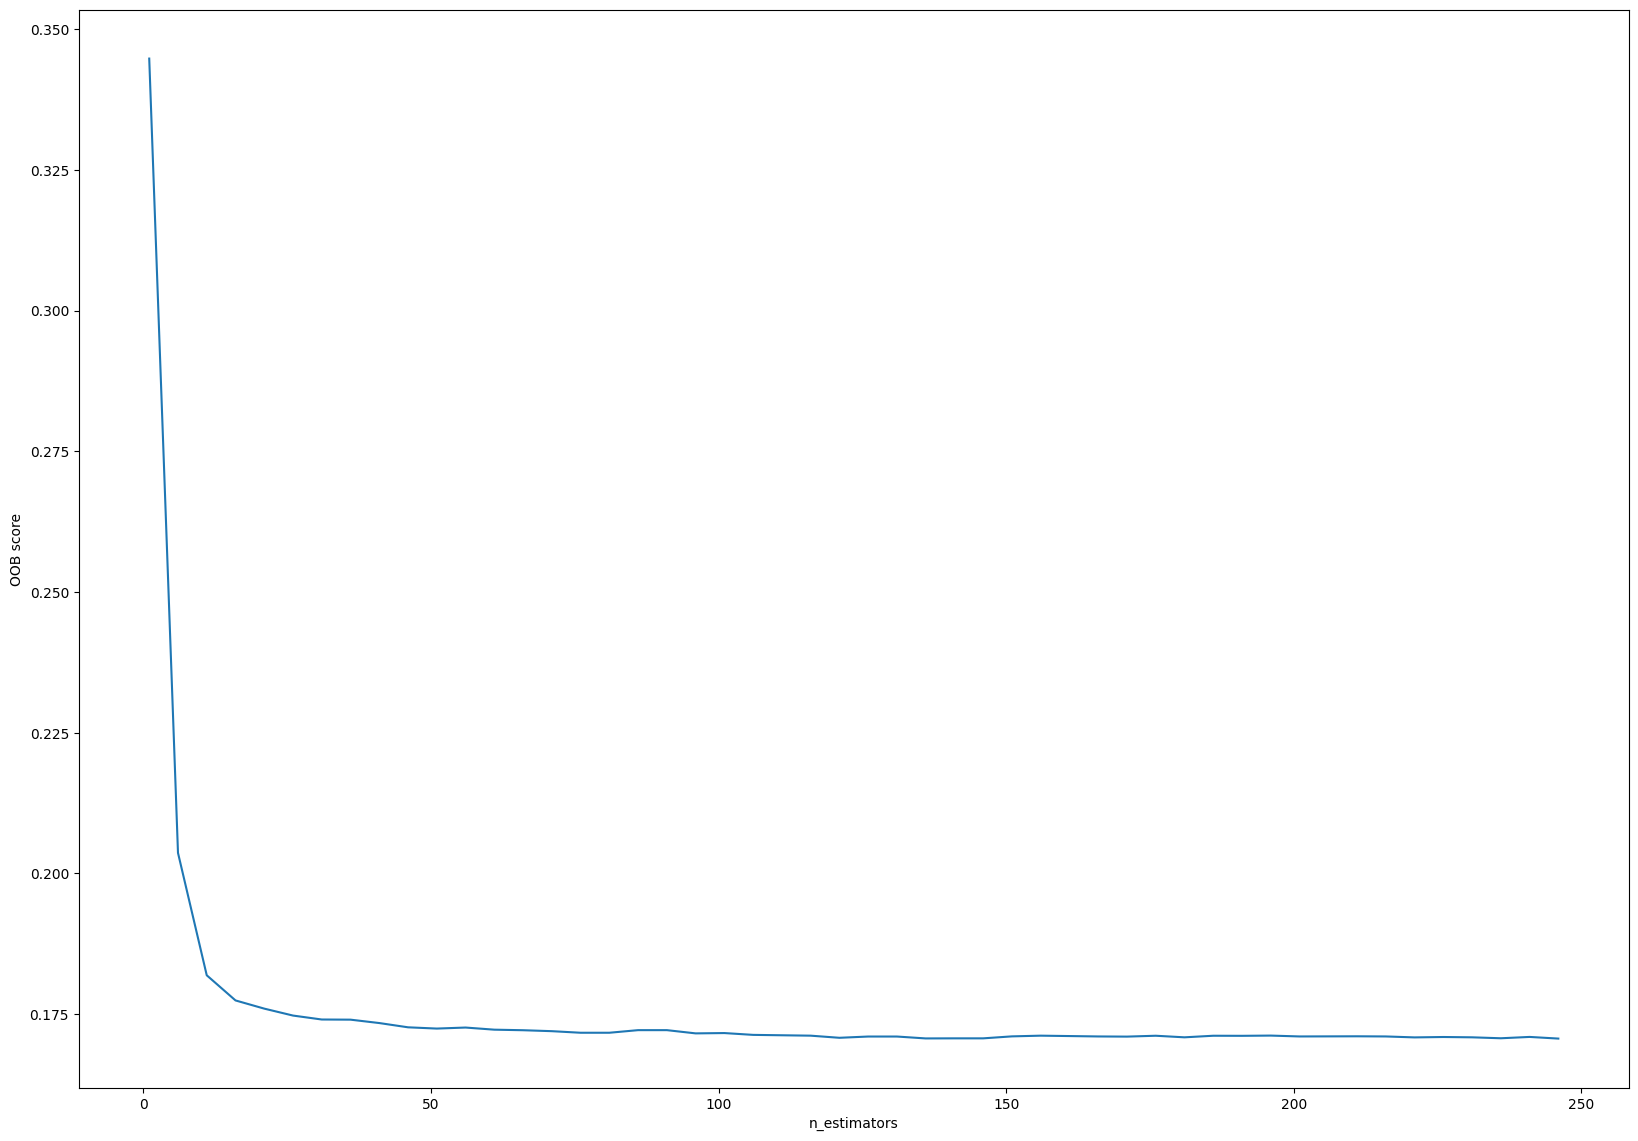

In [39]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


Лучшим случайным лесом оказался RandomForest без подбора гиперпараметров

In [ ]:
rf.feature_importances_

array([0.03420022, 0.04214534, 0.01171079, 0.01306905, 0.14285989,
       0.0184862 , 0.03666046, 0.01605055, 0.01337316, 0.17970493,
       0.0422916 , 0.05721543, 0.03204131, 0.04331111, 0.02589419,
       0.02493829, 0.025174  , 0.02598002, 0.00467822, 0.03425874,
       0.10150307, 0.06826165, 0.00619178])

In [ ]:
dt_model.feature_importances_

array([0.01557909, 0.01313155, 0.00282084, 0.00658349, 0.20011634,
       0.00333983, 0.00436197, 0.01288821, 0.00248703, 0.39081423,
       0.01421861, 0.04036754, 0.00657614, 0.0203668 , 0.01647106,
       0.02868852, 0.0149422 , 0.0084324 , 0.00078207, 0.0312251 ,
       0.146853  , 0.01693278, 0.0020212 ])

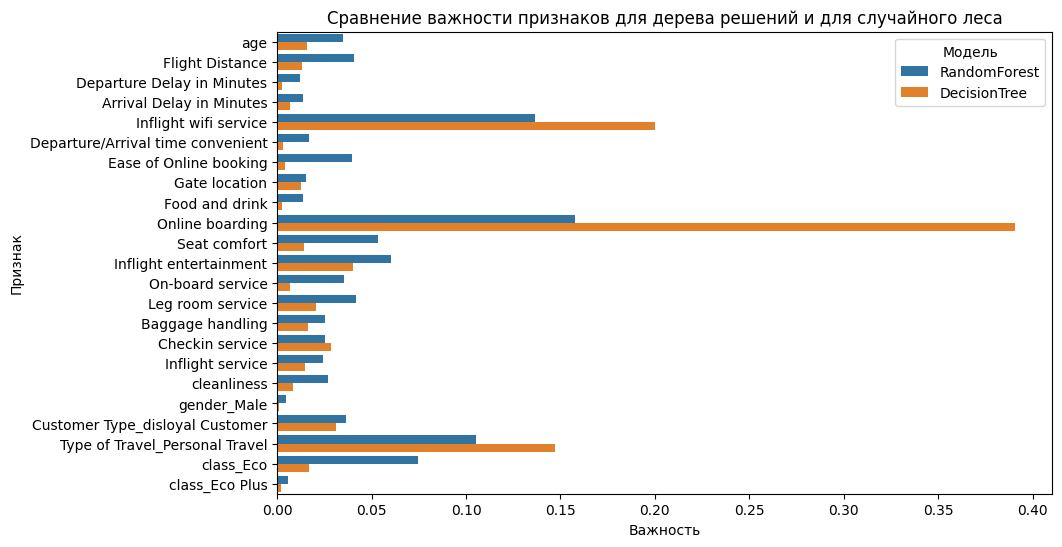

In [ ]:
df_tree_features = pd.DataFrame({
    'Feature': X_train_enc.columns,
    'RandomForest': rf.feature_importances_,
    'DecisionTree': dt_model.feature_importances_
})

df_tree_features_melt = df_tree_features.melt(id_vars='Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Model', data=df_tree_features_melt)
plt.title('Сравнение важности признаков для дерева решений и для случайного леса')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.legend(title='Модель')
plt.show()

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [ ]:
with open('RF.pkl', 'wb') as file:
    pickle.dump(rf, file)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
X_train_enc_mini = X_train_enc.sample(1000, random_state=42)

Отображу график важности признаков для одного из классов...

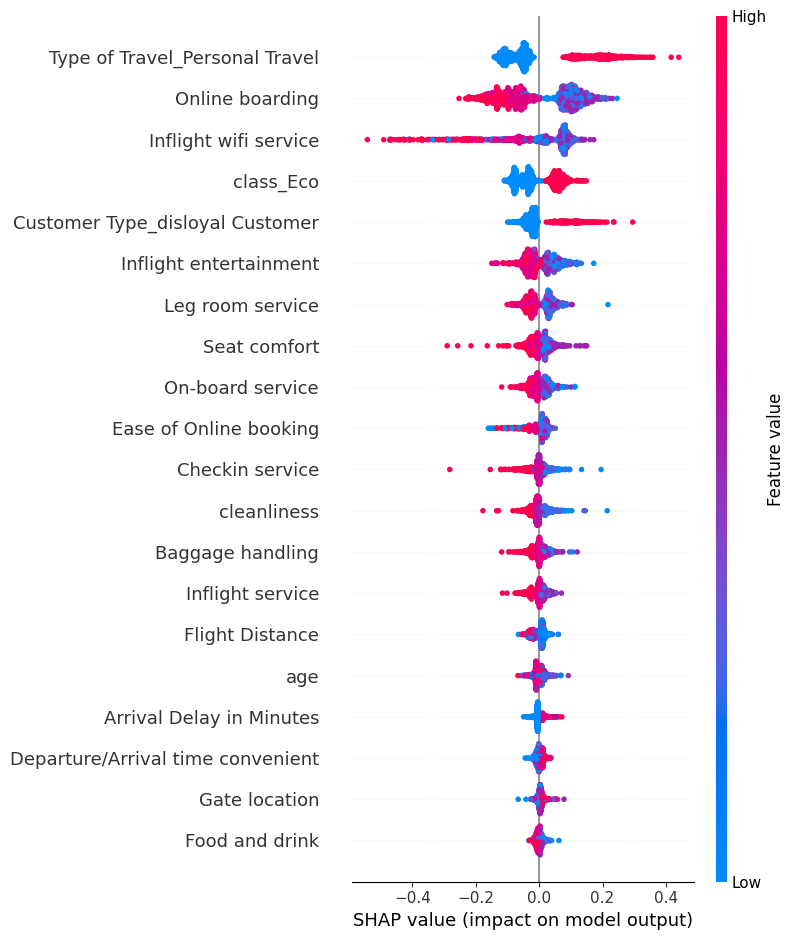

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_test = explainer(X_train_enc_mini)
# Не нашел в интернете описания этой ошибки - без перебора shape_test показывался урезанный график из 2 признаков.
# Вероятно, вместо предсказываемых классов попадали признаки
# Надеюсь, правильно перебрал shap_test
shap.summary_plot(shap_test[:,:,0], X_train_enc_mini)

Признаки размещены по важности сверху-вниз. **Самые значимые признаки - Type of Travel_Personal Travel, Online boarding и Inflight wifi service**.   Признаки, размещенные внизу оказывают самое малое влияние на предсказание модели.  
По оси X видно, на сколько сильно каждый признак влиял на предсказание класса. К примеру, большие значения (красные) Type of Travel_Personal Travel увеличивают предсказание первого класса, низкие значения (синие) будут уменьшать предсказание.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

https://shap.readthedocs.io/en/latest/index.html

* Есть различные explainer-ы для разных типов моделей
* Множество способов визуализации
* Совместимость с другими библиотеками

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

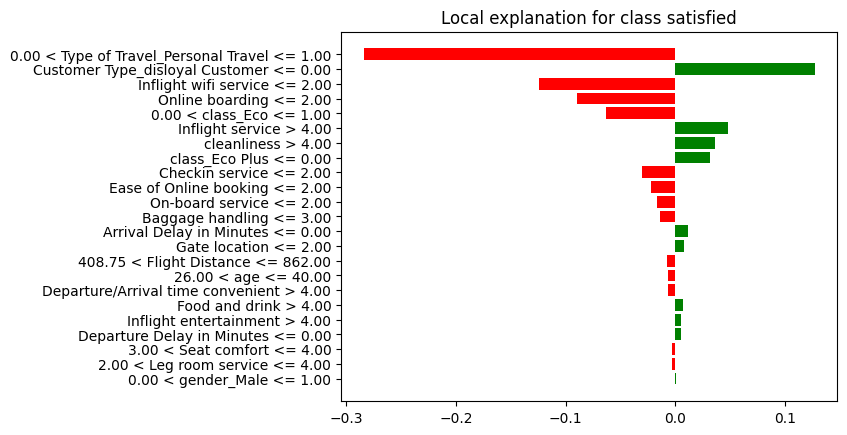

In [ ]:
# Сделано по примеру из https://habr.com/ru/companies/otus/articles/779430/

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_enc_mini.values, feature_names=X_train_enc_mini.columns, class_names=['neutral or dissatisfied', 'satisfied'], discretize_continuous=True)
i = 33  # пример для интерпретации
exp = explainer.explain_instance(X_train_enc_mini.iloc[i].values, rf.predict_proba, num_features=23)

exp.as_pyplot_figure()
plt.show()

ризнаки размещены по важности сверху-вниз. **Самые значимые признаки - Type of Travel_Personal Travel, Customer Type_disloyal Customer и Inflight wifi service**. Наименее важный признак - пол клиента. Красным цветом отмечены признаки, которые оказывают отрицательное влияние на предсказане класса, находясь в заданном интервале, зеленым - положительное.

**Предсказание для объектов без целевой переменной...**

In [ ]:
pred_test = rf.predict(df_test_enc)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
df_result = df_test.copy()
df_result['satisfaction'] = ['neutral or dissatisfied' if val == 0 else 'satisfied' for val in pred_test]

In [ ]:
df_result.head()

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
5     Male  36.0  Loyal Customer  Business travel  Business           3655.0   
7   Female  70.0  Loyal Customer  Personal Travel       Eco            108.0   
12    Male  66.0  Loyal Customer  Personal Travel       Eco            562.0   
19  Female  60.0  Loyal Customer  Business travel  Business           3756.0   
24    Male  43.0  Loyal Customer  Personal Travel  Business            802.0   

    Departure Delay in Minutes  Arrival Delay in Minutes  \
5                     3.713572                  4.276666   
7                     3.931826                  3.737670   
12                    4.488636                  4.442651   
19                    3.610918                  3.218876   
24                    0.000000                  0.000000   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
5                     1.0                                1.0  ...   
7                     5.0                                4.0  ...   
12                    2.0                                5.0  ...   
19                    4.0                                4.0  ...   
24                    1.0                                2.0  ...   

    Online boarding  Seat comfort  Inflight entertainment  On-board service  \
5               3.0           3.0                     3.0               3.0   
7               4.0           4.0                     3.0               3.0   
12              2.0           5.0                     5.0               3.0   
19              4.0           5.0                     4.0               4.0   
24              3.0           3.0                     2.0               2.0   

    Leg room service  Baggage handling  Checkin service  Inflight service  \
5                3.0               1.0              4.0               3.0   
7                0.0               3.0              5.0               3.0   
12               5.0               2.0              5.0               5.0   
19               4.0               4.0              5.0               4.0   
24               1.0               2.0              3.0               2.0   

    cleanliness             satisfaction  
5           2.0  neutral or dissatisfied  
7           5.0                satisfied  
12          5.0  neutral or dissatisfied  
19          5.0                satisfied  
24          1.0  neutral or dissatisfied  

[5 rows x 23 columns]

In [ ]:
df_result.to_csv("result.csv")

## Котобонус!

0.25 балла

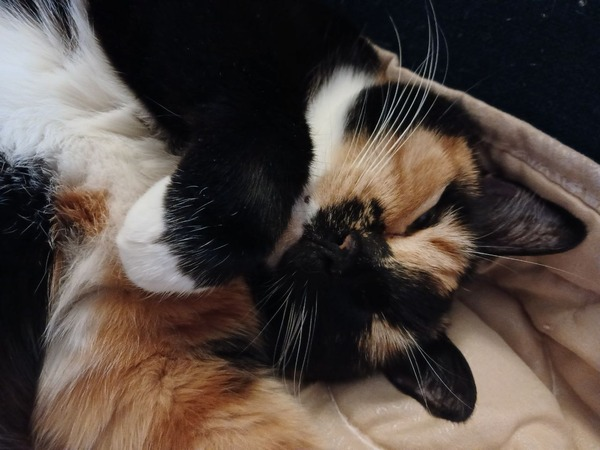

Считаю, что это питомец Елены Кантонистовой

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Задание сложное на 8/10. На выполнение потратил пару часов на протяжении 3-х дней.  
Задание полезное - пока решал задачи ознакомился с несколькими статьями, научился лучше понимать деревья и лес.  
Все супер!